<h1><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>Automatic Ticket Classification - EDA
</span></h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports

import os
import math
import random
import warnings
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from langdetect import detect_langs, LangDetectException
from wordcloud import WordCloud, STOPWORDS
from ftfy import fix_text
from sklearn.preprocessing import LabelEncoder
import tensorflow

tqdm.pandas()
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Users\surya\anaconda3\envs\full\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import & Analyse the data.</span></strong></li>
</ul></h3>

In [4]:
dataset = pd.read_excel('./data/input_data.xlsx')
dataset.sample(7)

Short description  \
5939  job SID_11_uacyltoe hxgaycze6 failed in job_sc...   
1056  job Job_2584 failed in job_scheduler at: 10/19...   
1371                 unable to log in to erp netweaver    
509   request to reset microsoft online services pas...   
635                            inquiry on impact awards   
1915  help to change the windows password using pass...   
1392                                    account lockout   

                                            Description             Caller  \
5939  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
1056  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
1371                 unable to log in to erp netweaver   lzqbyner jyncfahz   
509   from: microsoft on behalf of company inc. [mai...  szrglyte stvyhzxn   
635   from: wauhocsk vxuikqaf \nsent: sunday, octobe...  wauhocsk vxuikqaf   
1915  help to change the windows password using pass...  tvrigdbl mjsepfda   
1392                                    account lockout  nrmjhuox ktuyqewp   

     Assignment group  
5939            GRP_5  
1056            GRP_8  
1371            GRP_0  
509             GRP_0  
635             GRP_0  
1915            GRP_0  
1392            GRP_0

In [5]:
dataset.shape  # very small dataset with only 8500 rows

(8500, 4)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [7]:
# rename column names for convenience
dataset = dataset.rename(columns={
    "Short description": "short_description",
    "Description": "description",
    "Caller": "caller",
    "Assignment group": "group"
    })

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  8492 non-null   object
 1   description        8499 non-null   object
 2   caller             8500 non-null   object
 3   group              8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [9]:
np.unique(dataset.group), len(np.unique(dataset.group))  # 74 different functional groups

(array(['GRP_0', 'GRP_1', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
        'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
        'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
        'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_3', 'GRP_30',
        'GRP_31', 'GRP_32', 'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36',
        'GRP_37', 'GRP_38', 'GRP_39', 'GRP_4', 'GRP_40', 'GRP_41',
        'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45', 'GRP_46', 'GRP_47',
        'GRP_48', 'GRP_49', 'GRP_5', 'GRP_50', 'GRP_51', 'GRP_52',
        'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56', 'GRP_57', 'GRP_58',
        'GRP_59', 'GRP_6', 'GRP_60', 'GRP_61', 'GRP_62', 'GRP_63',
        'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69',
        'GRP_7', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73', 'GRP_8', 'GRP_9'],
       dtype=object),
 74)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Check for Incomplete Information</span></strong></li>
</ul></h3>

In [10]:
dataset.isna().sum()  # Few missing values

short_description    8
description          1
caller               0
group                0
dtype: int64

In [11]:
dataset[dataset.isna().any(axis=1)]  # check rows with missing values

short_description  \
2604                       NaN   
3383                       NaN   
3906                       NaN   
3910                       NaN   
3915                       NaN   
3921                       NaN   
3924                       NaN   
4341                       NaN   
4395  i am locked out of skype   

                                            description             caller  \
2604  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...  ohdrnswl rezuibdt   
3383  \r\n-connected to the user system using teamvi...  qftpazns fxpnytmk   
3906  -user unable  tologin to vpn.\r\n-connected to...  awpcmsey ctdiuqwe   
3910  -user unable  tologin to vpn.\r\n-connected to...  rhwsmefo tvphyura   
3915  -user unable  tologin to vpn.\r\n-connected to...  hxripljo efzounig   
3921  -user unable  tologin to vpn.\r\n-connected to...  cziadygo veiosxby   
3924  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...  wvqgbdhm fwchqjor   
4341  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...  eqmuniov ehxkcbgj   
4395                                                NaN  viyglzfo ajtfzpkb   

       group  
2604  GRP_34  
3383   GRP_0  
3906   GRP_0  
3910   GRP_0  
3915   GRP_0  
3921   GRP_0  
3924   GRP_0  
4341   GRP_0  
4395   GRP_0

In [12]:
dataset.loc[dataset['description'].isna()]

short_description description             caller  group
4395  i am locked out of skype         NaN  viyglzfo ajtfzpkb  GRP_0

In [13]:
dataset.iloc[4395]

short_description    i am locked out of skype
description                               NaN
caller                      viyglzfo ajtfzpkb
group                                   GRP_0
Name: 4395, dtype: object

In [14]:
# imputing the short description by value in description and vice-versa
# However, If both columns were missing, we would have to drop the row
dataset.loc[dataset['description'].isna(), 'description']  = dataset.loc[dataset['description'].isna()].short_description

In [15]:
dataset.loc[dataset['short_description'].isna()]

short_description                                        description  \
2604               NaN  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...   
3383               NaN  \r\n-connected to the user system using teamvi...   
3906               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3910               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3915               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3921               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3924               NaN  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...   
4341               NaN  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...   

                 caller   group  
2604  ohdrnswl rezuibdt  GRP_34  
3383  qftpazns fxpnytmk   GRP_0  
3906  awpcmsey ctdiuqwe   GRP_0  
3910  rhwsmefo tvphyura   GRP_0  
3915  hxripljo efzounig   GRP_0  
3921  cziadygo veiosxby   GRP_0  
3924  wvqgbdhm fwchqjor   GRP_0  
4341  eqmuniov ehxkcbgj   GRP_0

In [16]:
dataset.loc[dataset['short_description'].isna(), 'short_description']  = dataset.loc[dataset['short_description'].isna()].description

In [17]:
dataset.isna().sum()  # all missing values imputed

short_description    0
description          0
caller               0
group                0
dtype: int64

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Target Class Distribution</span></strong></li>
</ul></h3>

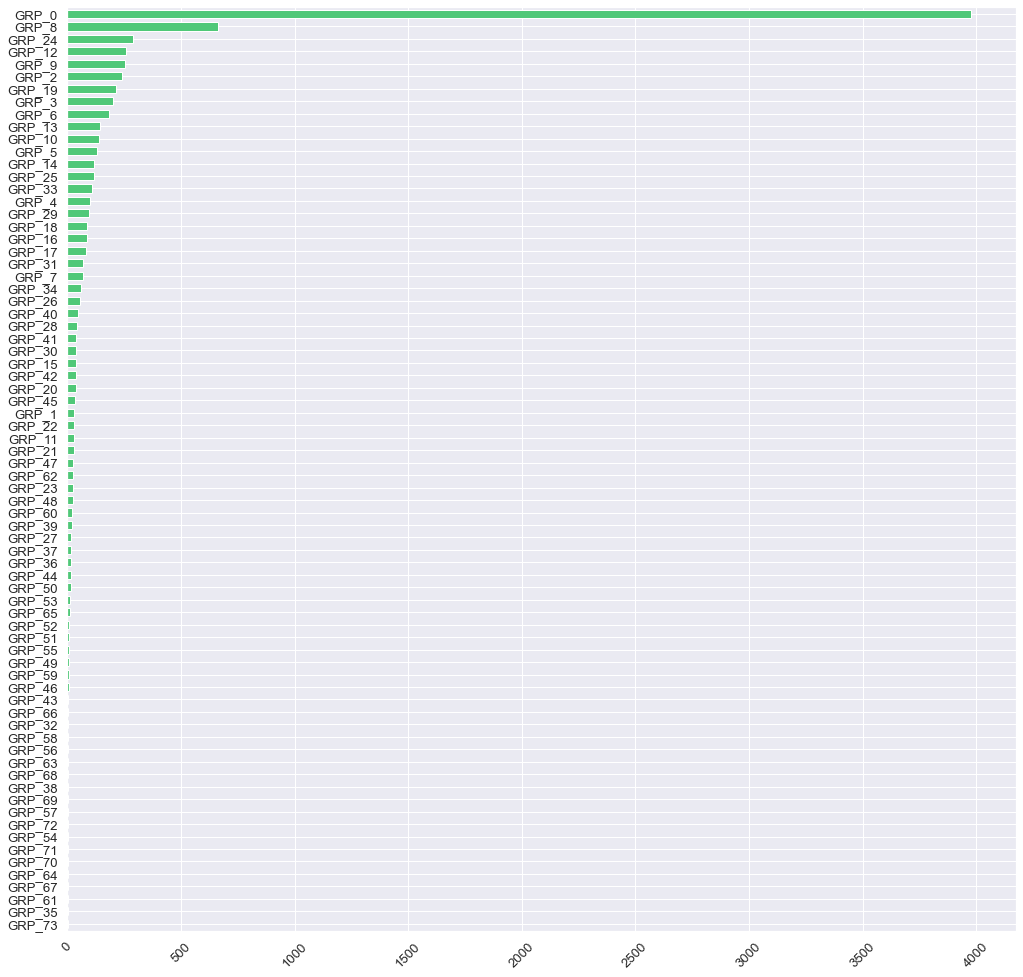

In [18]:
sns.set(font_scale=1.2)  # scale up font size
dataset.group.value_counts().sort_values(ascending=True).plot(kind='barh', width=0.65, figsize=(17, 17), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [19]:
dataset.group.value_counts().sort_values(ascending=False).tail(30)  # few classes with only single-digit datapoints

GRP_36    15
GRP_44    15
GRP_50    14
GRP_53    11
GRP_65    11
GRP_52     9
GRP_51     8
GRP_55     8
GRP_49     6
GRP_59     6
GRP_46     6
GRP_43     5
GRP_66     4
GRP_32     4
GRP_58     3
GRP_56     3
GRP_63     3
GRP_68     3
GRP_38     3
GRP_69     2
GRP_57     2
GRP_72     2
GRP_54     2
GRP_71     2
GRP_70     1
GRP_64     1
GRP_67     1
GRP_61     1
GRP_35     1
GRP_73     1
Name: group, dtype: int64

In [20]:
dataset[dataset.group == 'GRP_70']  # small groups have to merged into a separate "Others" category

short_description  \
6401  a link on an e-mail says i am "forbidden"   

                                            description             caller  \
6401  an e-mail from  it training has email hints an...  mfvkxghn mzjasxqd   

       group  
6401  GRP_70

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>The target class distribution is heavily imbalanced as most calls are assinged to Group 0 and exluding this as well, we find an imabalanced dataset for the rest of the groups.
 </span></ul></h5>

In [21]:
temp = dataset.copy(deep=True)
temp.loc[temp["group"] != 'GRP_0', 'group'] = 'Other'
temp.loc[temp["group"] == 'GRP_0', "group"] = 'Group 0'

In [22]:
temp.group.value_counts()

Other      4524
Group 0    3976
Name: group, dtype: int64

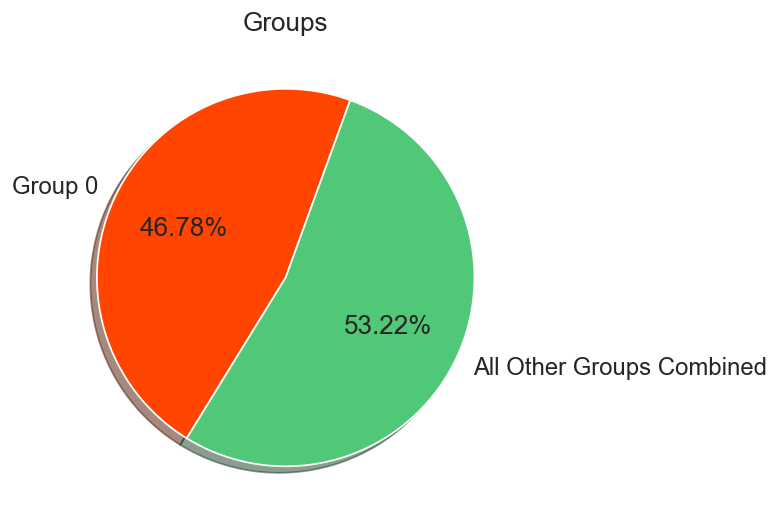

In [23]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
group_0 = len(temp[temp['group'] == 'Group 0'])
others = len(temp[temp['group'] == 'Other'])

plt.pie(x=[group_0, others],
        explode=(0, 0),
        labels=['Group 0', 'All Other Groups Combined'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Groups')
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Choosing a Metric to benchmark model performance</span></strong></li>
</ul></h3>

* This is a multi-class classification problem, where the machine learning model will try to predict if each row is one of the 74 possibilities.
* The majority class is GRP_0, which occurs in 46.78% of the observations.

* The most common metrics for a multi-class classification problem are AUC, F1-score and accuracy.
* Accuracy is not suitable for an imbalanced classification problem. (Note that a model that always predicts GRP_0, will get an accuracy of 46.78%)
* We would choose F1-score if the majority class is more important than the smaller classes.
* We would choose AUC if we also care about the smaller classes.

#### As we want to be able to classify the tickets into all functional groups and functional groups are given equal importance, we choose AUC as the final metric to score model performance.

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Outlier Analysis</span></strong></li>
</ul></h3>

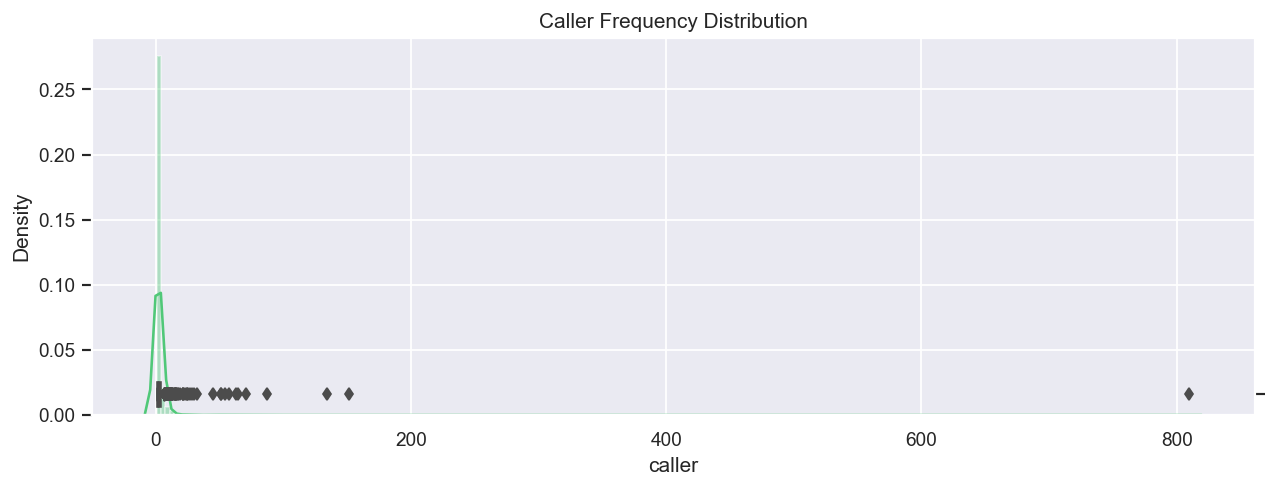

In [24]:
# plotting caller frequency counts
sns.set()
plt.figure(figsize=(12, 4), dpi=125)
ax = sns.distplot(dataset.caller.value_counts(), bins=250, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.caller.value_counts(), color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Caller Frequency Distribution')
plt.show()

In [25]:
def get_length(row):
    try:
        row['char_length'] = len(row.description)
        row['word_length'] = len(row.description.split())
        row['short_char_length'] = len(row.short_description)
        row['short_word_length'] = len(row.short_description.split())
    except Exception:  # assign 0 length to missing rows if any
        row['char_length'] = 0
        row['word_length'] = 0
        row['short_char_length'] = 0
        row['short_word_length'] = 0
    return row

dataset = dataset.progress_apply(get_length, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 8500/8500 [00:14<00:00, 577.91it/s]


In [26]:
dataset.sample(7)

short_description  \
2456                                      changes in ad   
1467  job SID_43filesys failed in job_scheduler at: ...   
2244              access to collaboration_platform link   
7985                                 ess password reset   
1455  need help in resetting password in password_ma...   
3912  referencing ticket ticket_no1499477. customer ...   
5883  setup new ws\ rechner alte schmiede \nfayqjhg ...   

                                            description             caller  \
2456  hi, there,\r\nmy reporting line in the outlook...  ywbnzxud qzwrynux   
1467  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
2244      access to collaboration_platform link\r\n\r\n  mfeyouli ndobtzpw   
7985                                 ess password reset  ariqehvd fhrpontd   
1455  need help in resetting password in password_ma...  axdyfojg nyjlxbsk   
3912  please revisit ticket ticket_no1499477 and rev...  xnqzhtwu hivumtfz   
5883  setup new ws\ rechner alte schmiede \nfayqjhg ...  nfayqjhg kyswcpei   

       group  char_length  word_length  short_char_length  short_word_length  
2456   GRP_2          247           44                 13                  3  
1467   GRP_8          111           11                 67                  8  
2244   GRP_0           41            4                 37                  4  
7985   GRP_0           18            3                 18                  3  
1455   GRP_0           59            7                 59                  7  
3912  GRP_20          291           47                102                 14  
5883  GRP_24           54            8                 54                  8

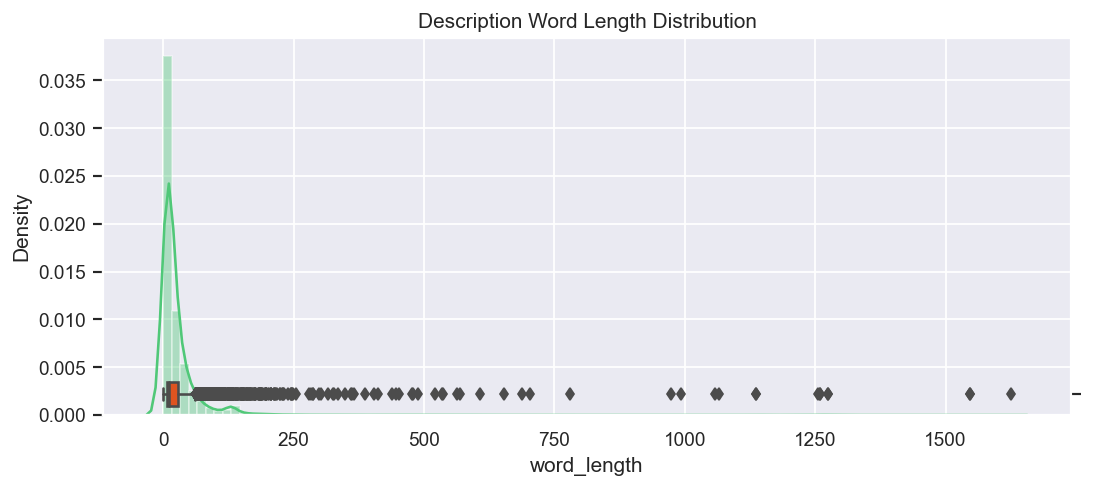

In [27]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.word_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.word_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Description Word Length Distribution')
plt.show()

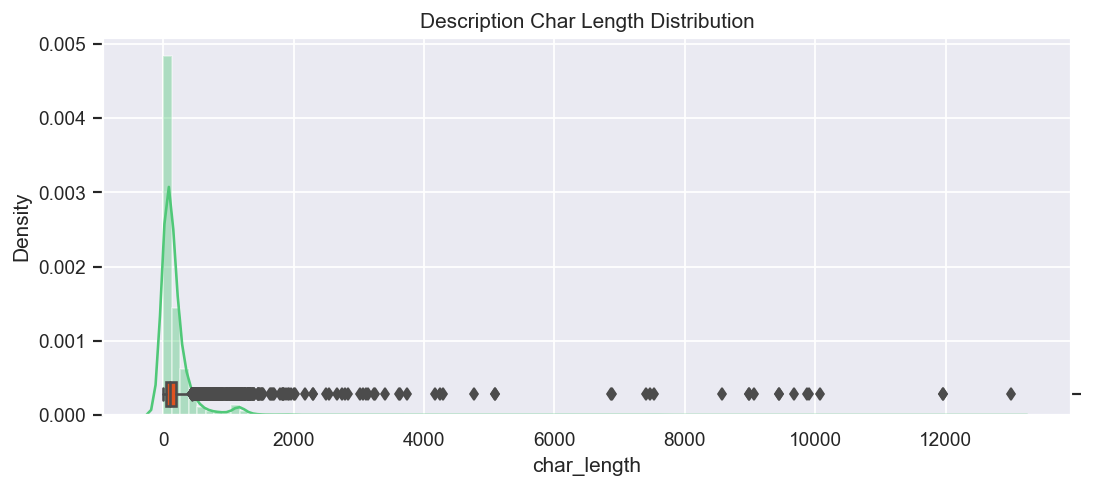

In [28]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.char_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.char_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Description Char Length Distribution')
plt.show()

In [29]:
dataset[dataset.word_length == 0]  # empty description => imputing with the corresponding short_description

short_description description             caller  group  \
6371   authorization add/delete members    \r\n\r\n  hpmwliog kqtnfvrl  GRP_0   
7397                   browser issue :         \r\n  fgejnhux fnkymoht  GRP_0   

      char_length  word_length  short_char_length  short_word_length  
6371            5            0                 33                  3  
7397            2            0                 16                  3

In [30]:
dataset.loc[dataset.word_length == 0, 'description'] = dataset.loc[dataset.word_length == 0]['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 8500/8500 [00:00<00:00, 11125.70it/s]


In [31]:
dataset[dataset.word_length == 0]  # cleaned

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [32]:
dataset[dataset.char_length < 4]  # description 'the' holds no information => imputed with short_description

short_description description  \
1049  reset passwords for soldfnbq uhnbsvqd using pa...         the   
1054  reset passwords for fygrwuna gomcekzi using pa...         the   
1144  reset passwords for wvdxnkhf jirecvta using pa...         the   
1184  reset passwords for pxvjczdt kizsjfpq using pa...         the   
1292  reset passwords for cubdsrml znewqgop using pa...         the   
1476  reset passwords for bnoupaki cpeioxdz using pa...         the   
1558  reset passwords for usa feathers using passwor...         the   
1693  reset passwords for eglavnhx uprodleq using pa...         the   
1834  reset passwords for hybiaxlk lawptzir using pa...         the   
1850  reset passwords for fylrosuk kedgmiul using pa...         the   
1851  reset passwords for fylrosuk kedgmiul using pa...         the   
1860                                                  s           s   
2151  reset passwords for gjisfonb odwfhmze using pa...         the   
2532  reset passwords for qwsjptlo hnlasbed using pa...         the   
2533  reset passwords for qwsjptlo hnlasbed using pa...         the   
2553  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2554  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2572  reset passwords for prgewfly ndtfvple using pa...         the   
2602  reset passwords for wxdvjoct ckxwtoam using pa...         the   
2605  reset passwords for ytzpxhql ntfxgpms using pa...         the   
2749  reset passwords for fkuqjwit jgcsaqzi using pa...         the   
2788  reset passwords for hzmxwdrs tcbjyqps using pa...         the   
3000  reset passwords for knemilvx dvqtziya using pa...         the   
3432                                                dds         dss   
3447  reset passwords for qoybxkfh dwcmxuea using pa...         the   
3692  reset passwords for mvhcoqed konjdmwq using pa...         the   
3693  reset passwords for mvhcoqed konjdmwq using pa...         the   
4055  reset passwords for jerydwbn gdylnaue using pa...         the   
4065  reset passwords for dmexgspl mruzqhac using pa...         the   
4672  reset passwords for robhyertyj f duca using pa...         the   
4978  reset passwords for davidthd robankm using pas...         the   
4984  reset passwords for cubdsrml znewqgop using pa...         the   
4991  reset passwords for davidthd robankm using pas...         the   
5074  reset passwords for mafgtnik -0 using password...         the   
5077  reset passwords for cÃ©sar abreu rghkiriuytes ...         the   
5182  reset passwords for yolktfas fyoxqgvh using pa...         the   
5228  reset passwords for ugawcoye jcfqgviy using pa...         the   
5305  reset passwords for qgilmtyc gmscovxa using pa...         the   
5317  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5482  reset passwords for qycgdfhz iqshzdru using pa...         the   
5708  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5839  reset passwords for cpmaidhj elbaqmtp using pa...         the   
5884  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6037  reset passwords for cesgrtar abgrtyreu using p...         the   
6058  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6693  reset passwords for pzjelyxg vstyaouc using pa...         the   
6764  reset passwords for horeduca ogrhivnm using pa...         the   
6819  reset passwords for wvdxnkhf jirecvta using pa...         the   
6963  reset passwords for patrcja szpilewska using p...         the   
7131  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7132  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7169  reset passwords for andrdgrtew p taneghrty usi...         the   
7630  reset passwords for jcmxerol nbfyczqr using pa...         the   
7875  reset passwords for esias bosch using password...         the   
8059  reset passwords for wptbgchj jutpdcqf using pa...         the   
8092  reset passwords for prgthyuulla ramdntythanjes...       

In [33]:
dataset[dataset.description == 's']  # holds no actual information with just one letter, has to be dropped

short_description description             caller  group  char_length  \
1860                 s           s  gzjtweph mnslwfqv  GRP_0            1   

      word_length  short_char_length  short_word_length  
1860            1                  1                  1

In [34]:
# drop row with description: 's'
dataset.drop(dataset[dataset.description == 's'].index, inplace=True)
dataset = dataset.progress_apply(get_length, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 8499/8499 [00:00<00:00, 10154.15it/s]


In [35]:
# description 'the' holds no information => imputed with corresponding short_description
dataset.loc[dataset.description == 'the', 'description'] = dataset.loc[dataset.description == 'the']['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 8499/8499 [00:00<00:00, 11052.05it/s]


In [36]:
# Single Word descriptions
dataset[dataset.word_length == 1].shape

(41, 8)

In [37]:
# dataset[dataset.word_length == 1].to_csv('./data/Single_Word_Descriptions.csv')
dataset[dataset.word_length == 1].sample(20)  # these have to be cleaned up and imputed later on

short_description  \
4569  i am not able to connect to my regular printer...   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼   
1954                        ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚   
5761                                 ä¸»æœºä¸èƒ½å¼€å¯   
415   reset passwords for prgewfly ndtfvple using pa...   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...   
5762       æ‰“å¼€office 2013æ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“   
7969               å®¢æˆ·æä¾›çš„åœ¨çº¿ç³»ç»Ÿæ‰“ä¸å¼€   
416   reset the password for prgewfly ndtfvple on er...   
5311                       ç³»ç»Ÿæ•…éšœï¼Œå¯åŠ¨è“å±.   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...   
7588                                    æ˜¾ç¤ºå™¨ä¸äº®   
618                                    outlookæ‰“ä¸å¼€   
3315                        ç”µè„‘ç³»ç»Ÿå¯åŠ¨è“å±ã€‚   
4505   request to reset microsoft online services pa...   
5146                                 walkmeåŠ è½½æ•…éšœ   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º   
4501                  åˆ¶ç²‰ä¸‰æ¥¼æŽ§åˆ¶å®¤ç”µè„‘æ•…éšœ   
4503                        ç”¨å‹å®šæœŸå¤‡ä»½ä¸æˆåŠŸ   

                                            description             caller  \
4569                                             x5380   koiapqbg teyldpkw   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼  spgdcvhb ocagnpmj   
1954               æŠŠæˆ‘çš„ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ  xjvubmlq vyamhjip   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚  ruhbyzpv vlksnjti   
5761  ä¸»æœºä¸èƒ½å¼€å¯ï¼Œç”µæºç¯æ­£å¸¸ï¼Œä¸»æœºé...  cpdilmjx jwsqpiac   
415                                            complete  prgewfly ndtfvple   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...  pvfclkmn gebyipwr   
5762  æ‰“å¼€outlookã€pptæ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“...  hbvwqine eakqyovu   
7969  å®¢æˆ·æä¾›çš„åœ¨çº¿é€è´§å•ç”Ÿæˆç³»ç»Ÿæ‰“ä...  fupikdoa gjkytoeh   
416                                           completed  prgewfly ndtfvple   
5311                      ç³»ç»Ÿæ•…éšœï¼Œå¯åŠ¨è“å±.   lhkqbmna ekhtivsd   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...  bxfdkiol mdqlszvc   
7588            æ—©ä¸Šå¼€æœºåŽæ˜¾ç¤ºå™¨ä¸å‡ºå›¾åƒã€‚  wgmqlnzh vpebwoat   
618   æ‰“å¼€outlookæ—¶ï¼Œæ˜¾ç¤ºoutlook.ostæ–‡ä»¶é”™è...  qayozbcd vwglmpjq   
3315  ç”µè„‘ç³»ç»Ÿå¯åŠ¨è“å±ã€‚æ°´ä¸å°å¿ƒæ´’åˆ°ç...  hdungfsc znuhyjkx   
4505                                      \r\n\r\nkind   rcfwnpbi kvhedyrc   
5146  walkmeä¸‹è½½å®‰è£…åŽï¼ŒæŒ‰é’®ä¸èƒ½åœ¨æµè§ˆå...  whflryeb fatgdzhq   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º  ehfvwltg eakjbtoi   
4501  åˆ¶ç²‰ä¸‰æ¥¼æŽ§åˆ¶å®¤ç”µè„‘ä¸èƒ½å¼€å¯ï¼Œç”µæ...  agyvbnwz mxsonkdc   
4503  æœåŠ¡å™¨ç«¯ç”¨å‹ç³»ç»Ÿæœ€è¿‘åŠä¸ªæœˆæ—¥å¤‡ä...  igdnsjhz awnftgev   

       group  char_length  word_length  short_char_length  short_word_length  
4569   GRP_0            6            1                 84                 16  
1452  GRP_30           39            1                 39                  1  
1954  GRP_30           36            1                 27                  1  
3120  GRP_30           36            1                 36                  1  
5761  GRP_48           71            1                 18                  1  
415   GRP_17            8            1                 84                  9  
4098  GRP_30           57            1                 57                  1  
5762  GRP_48           59            1                 44                  2  
7969  GRP_48           69            1                 36                  1  
416    GRP_0            9            1                 67                 12  
5311  GRP_31           29            1                 28                  1  
276   GRP_30           73            1                 73                  1  
7588  GRP_30           39            1                 15                  1  
618    GRP_0           72            1               

In [38]:
dataset[dataset.word_length == 2].sample(20)

short_description  \
4956                                    password reset    
4091  reset passwords for hgyvopct dhckfmbq using pa...   
1255                                    account locked.   
1021                                     german caller    
8401                               company screensaver    
6286                                        bios update   
1390                                        phone issue   
1525                                    account locked.   
3829  problem with hagemeyer oci shop in SID_34 purc...   
7886                             engineering_tool error   
8194                                    general enquiry   
7517                                     password issue   
4630                                    password reset    
5045                                     konto resetten   
3636                                        blank call    
956                       collaboration_platform issue    
5580                            outlook ä¸èƒ½å¯åŠ¨ã€‚   
1761                                    outlook freezes   
3419                                   office reinstall   
2045                                  uacyltoe hxgaycze   

                            description             caller   group  \
4956                    password reset   ajlbguzn fxrwivyg   GRP_0   
4091  è¯·å°†å¯†ç è®¾ç½®ä¸ºï¼šsdguo1609  hgyvopct dhckfmbq  GRP_17   
1255                    account locked.  ewvibrfg atlurzdn   GRP_0   
1021                     german caller   pwkrlqbc zslqfmka   GRP_0   
8401               company screensaver   eagvusbr nguqityl   GRP_0   
6286                        bios update  jvshydix rzpmnylt   GRP_0   
1390                        phone issue  gzjtweph mnslwfqv   GRP_0   
1525                    account locked.  ndrtahvm kjhdybzm   GRP_0   
3829                   as discussed\r\n  rhinvtua aquyjfbs  GRP_29   
7886             engineering_tool error  mofjyqrh bcyzmkia   GRP_0   
8194                    general enquiry  rbozivdq gmlhrtvp   GRP_0   
7517                     password issue  qmglkaru qiwhfkdv   GRP_0   
4630                    password reset   cbmryjid nkcmvwgi   GRP_0   
5045                     konto resetten  ughzilfm cfibdamq   GRP_0   
3636                        blank call   fumkcsji sarmtlhy   GRP_0   
956        collaboration_platform issue  mknoeicg aziptqvu   GRP_0   
5580            outlook ä¸èƒ½å¯åŠ¨ã€‚  ebkmczgy pbzfgcoa  GRP_31   
1761                   outlook freezes.  techruxg wasrvkuz   GRP_0   
3419                   office reinstall  ejvkzobl yijgokrn   GRP_0   
2045                  uacyltoe hxgaycze  xweclugf qmhbjsyi  GRP_12   

      char_length  word_length  short_char_length  short_word_length  
4956           15            2                 15                  2  
4091           33            2                 84                  9  
1255           15            2                 15                  2  
1021           14            2                 14                  2  
8401           20            2                 20                  2  
6286           11            2                 11                  2  
1390           11            2                 11                  2  
1525           15            2                 15                  2  
3829           14            2                 52                  8  
7886           22            2                 22                  2  
8194           15            2                 15                  2  
7517           14            2                 14                  2  
4630           15            2                 15                  2  
5045           14            2                 14                  2  
3636           11            2                 11                  2  
956            28            2                 29                  2  
5580           23            2                 23                  2  
1761           16            2                 15

In [39]:
dataset[dataset.short_word_length == 0]  # all have short descriptions

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [40]:
dataset[dataset.short_char_length < 3]

short_description                                        description  \
3529                PR  create a purchase requisition with purchasing ...   

                 caller   group  char_length  word_length  short_char_length  \
3529  ejvkzobl yijgokrn  GRP_29          201           31                  2   

      short_word_length  
3529                  1

In [41]:
dataset[dataset.char_length < 4]  

short_description description             caller  group  char_length  \
3432               dds         dss  onctqhsg cpahzsle  GRP_0            3   

      word_length  short_char_length  short_word_length  
3432            1                  3                  1

In [42]:
dataset[dataset.word_length > 800]  # security incident logs

short_description  \
3530  security incidents - ( #in33944691 ) : possibl...   
3965  security incidents - ( #in33809307 ) : possibl...   
4087  security incidents - ( sw #in33895560 ) : mage...   
4089  security incidents - ( sw #in33895560 ) : mage...   
5092  security incidents - ( #in33578632) : suspicio...   
5433  security incidents - ( #in33765965 ) : possibl...   
7345  security incidents - ( sw #in33501789 ) : broa...   
7647  security incidents - ( #in33578632) : suspicio...   
7982  security incidents - ( dsw #in33390850 ) : sus...   
7984  security incidents - ( dsw #in33390850 ) : sus...   
7989  security incidents - ( dsw #in33407676 ) : tra...   
7995  security incidents - ( dsw #in33407676 ) : tra...   
7997  security incidents - ( sw #in33544563 ) : poss...   
8002  security incidents - ( sw #in33544563 ) : poss...   

                                            description             caller  \
3530  source ip: 195.272.28.222\nsource port: 80\nso...  gzhapcld fdigznbk   
3965  source ip :195.22.28.222 \nsystem name :androi...  gzhapcld fdigznbk   
4087  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
4089  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
5092  source ip: 29.26.13.3095\r\nsource hostname: H...  gzhapcld fdigznbk   
5433  source ip :10.40.6.221\nsystem name :rqxl85172...  gzhapcld fdigznbk   
7345  we are seeing activity indicating the host at ...  ugyothfz ugrmkdhx   
7647  source ip :\r\nsystem name :\r\nuser  name:\r\...  gzhapcld fdigznbk   
7982  source ip : 78.83.16.293\nsystem name : HostNa...  ugyothfz ugrmkdhx   
7984  source ip : 78.83.16.293\r\nsystem name : Host...  ugyothfz ugrmkdhx   
7989  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7995  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7997  source ip : 45.25.35.0499\nsystem name : lpal9...  ugyothfz ugrmkdhx   
8002  source ip : 45.25.35.0499\r\nsystem name : lpa...  ugyothfz ugrmkdhx   

       group  char_length  word_length  short_char_length  short_word_length  
3530   GRP_2         7524          974                111                 17  
3965   GRP_2         8988         1255                116                 17  
4087  GRP_39        11968         1547                 63                 11  
4089   GRP_2        11968         1547                 63                 11  
5092   GRP_3         9063         1066                 92                 11  
5433   GRP_2         8575         1057                 83                 13  
7345   GRP_2        13001         1625                102                 14  
7647   GRP_2         8991          993                 92                 11  
7982   GRP_2         9881         1137                118                 17  
7984  GRP_12        10077         1137                118                 17  
7989   GRP_2         9440         1275                109                 18  
7995  GRP_62         9440         1275                109                 18  
7997   GRP_2         9678         1260                107                 16  
8002  GRP_62         9912         1260                107                 16

In [43]:
dataset[dataset.word_length > 200][dataset.word_length < 800]

short_description  \
238   erp pi and msd crm connectivity issue- serirtc...   
239                 printer problem / issue information   
981   employment status - new non-employee ycgkinov ...   
1175  bitte das iphone-6 001 freischalten fÃ¼r mail-...   
1179  media server disconnect lpapr952(south_amerirt...   
1577  the printer is defaulting to the usa printer f...   
1696  mm:pur_req_ko assign for user: yeyhtung kimthy...   
1812  sales orders are not updating with correct del...   
1855  printer problem / issue information -- zebra l...   
2082        printing language sa38 (reporting rfumsv00)   
2370  update inwarehouse_tool documents from list fo...   
2445  vh 27 - werk germany - fehlende druckauftrÃ¤ge...   
2492  printing request - request transaction print t...   
2741  i have lost my access to reporting_tool in crm...   
2879                           mobile device activation   
2978  security incidents - ( #in33987594) : 29866 vi...   
3097  security incidents - ( #in33976733) : suspicio...   
3098  security incidents - ( #in33984033) : internal...   
3165  partial confirmation info sent to erp but mach...   
3325                                            it help   
3382                                       support with   
3532  security incidents - ( #in33944327) :possible ...   
3705  security incidents - ( #in33932723 ) : possibl...   
3706  security incidents - ( #in33924718 ) : possibl...   
3718                     re: need a little help--please   
3961  security incidents - ( #in33805815) : possible...   
4382                printer problem / issue information   
4730  security incidents - (  #in33847938) : possibl...   
4825   incident #in33541962 - phishing form submit -...   
4853         bahdqrcs xvgzdtqj's onbankrding experience   
4886  security incidents - ( #in33826812 ) : possibl...   
4893  security incidents - ( #in33826812 ) : possibl...   
5072  erp-step interface programdnty not sending all...   
5204  employment status - three new non-employee [en...   
5394                                              hana    
5485               printer problem / issue information    
5503                                     dsw in22210104   
5504   incident #in33541962 - phishing form submit -...   
5506                                     dsw in22457494   
5507  possible vulnerability scan from host.my-tss.c...   
5697                printer problem / issue information   
5787  windows asks to install driver and then won't ...   
6017     open order schedule lines_p2016-08-28-22-03-54   
6734  security incidents - ( dsw incident no ) : sus...   
6888  security incidents - (#in33655554) : errata se...   
6931  '51551 vid67965 microsoft windows httpsys rce ...   
7163  symantec endpoint encryption (see) agent roll ...   
7331  security incidents - ( #in33505432 ) : repeat ...   
7338  security incidents - ( #in33505432 ) : repeat ...   
7433  zpdist_programdnty not allowing to distribute ...   
7553                    wifi slow speed-company (apac)    
7981  as per inc1530176::security incidents - (in335...   
7987  security incidents - (in33536629) : possible t...   
7991  as per inc1530161::security incidents - ( in33...   
7996  security incidents - ( in33490582 ) : suspicio...   
8160                                  release of device   
8232  stepfhryhan needs access to below collaboratio...   
8339     unlock account  email  in cell phone the users   

                                            description             caller  \
238   hi all\n\nwe have a connectivity issue between...  kgytujhe bonhwzrx   
239   please complete all required questions below. ...  dzjxrkae grqczsmx   
981   *page down to ensure that all required data fi...  lfikjasz tjbqcmvl   
1175  \n\nreceived from: rtnyumbg.yzemkhbq@gmail.com...  rtnyumbg yzemkhbq   
1179  received below email from inin tried to ping t...  jloygrwh acvztedi   
1577  from: kryuisti turleythy \nsent: wednesday, oc...  hybiaxlk lawptzir   
1696  mm:p

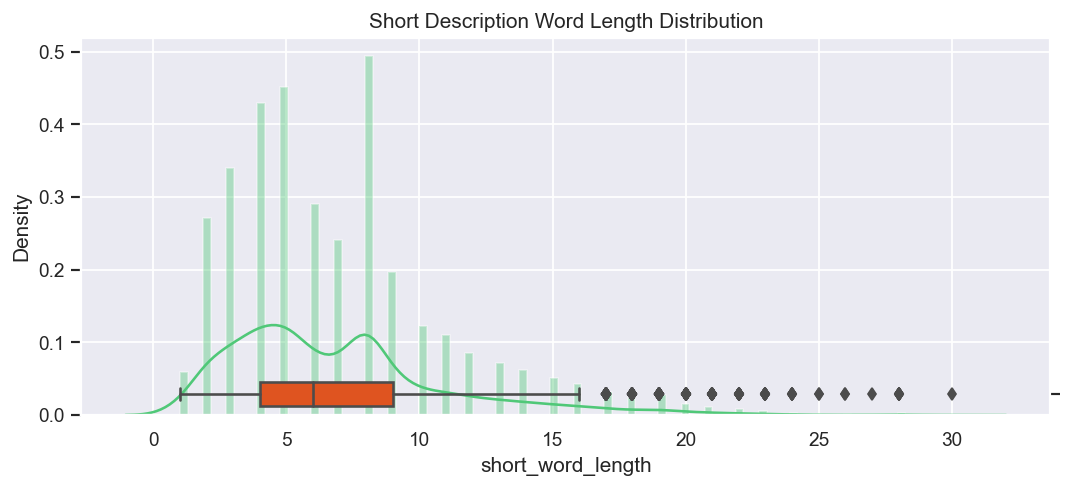

In [44]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_word_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.short_word_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Word Length Distribution')
plt.show()

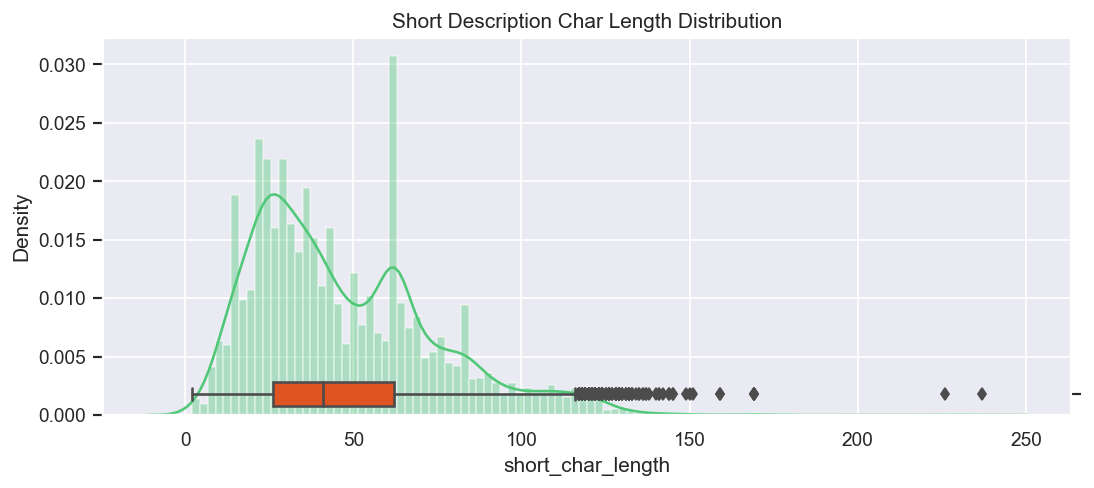

In [45]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_char_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.short_char_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Char Length Distribution')
plt.show()

In [46]:
dataset.describe()

char_length  word_length  short_char_length  short_word_length
count   8499.000000  8499.000000        8499.000000        8499.000000
mean     204.595246    27.331804          47.386751           6.951759
std      519.530803    65.026307          27.323700           4.158631
min        3.000000     1.000000           2.000000           1.000000
25%       42.000000     6.000000          26.000000           4.000000
50%      106.000000    11.000000          41.000000           6.000000
75%      201.000000    28.000000          62.000000           9.000000
max    13001.000000  1625.000000         237.000000          30.000000

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Most descriptions have between 6 and 28 words long with median at 41 (106 characters) and mean at 27.2 with relatively few outliers ranging till 1625 words!<br>
    <li>Most Short descriptions have between 4 and 9 words long with median at 6 (41 characters) and mean at 6.92 with relatively few outliers ranging till 28 words.<br>
 </span></ul></h5>

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Fix Text Encoding</span></strong></li>
</ul></h3>

In [47]:
dataset[dataset.word_length == 1].sample(20)

short_description  \
5762       æ‰“å¼€office 2013æ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“   
6534                  æ¶‚å±‚ã€ç®¡ä¸è½¦é—´ç”µè¯æ•…éšœ   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...   
5149                                       å¼€ä¸äº†æœº   
1704                                    è´¦æˆ·è¢«é”å®š   
4505   request to reset microsoft online services pa...   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...   
1399  i cant see my archived emails in outlook.  i a...   
3432                                                dds   
2267  urgent help required- outlook to crm mfg_toolt...   
7302                               skypeä¼šè®®æ—¶ä¸åŽ»   
7588                                    æ˜¾ç¤ºå™¨ä¸äº®   
415   reset passwords for prgewfly ndtfvple using pa...   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚   
1955                     æœ‰ä¸€ä¸ªé“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€   
1081                                 ç”¨å‹è½¯ä»¶é—®é¢˜   
1954                        ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ   
5146                                 walkmeåŠ è½½æ•…éšœ   
6106                                 ç”µè„‘ä¸èƒ½å¼€æœº   
2915             websites not loading on company center   

                                            description             caller  \
5762  æ‰“å¼€outlookã€pptæ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“...  hbvwqine eakqyovu   
6534  æ¶‚å±‚ã€ç®¡ä¸è½¦é—´ç”µè¯æ•…éšœï¼Œ40634943ã€...  vrmpysoz qkiucpdx   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...  pvfclkmn gebyipwr   
5149               å¼€ä¸äº†æœºï¼Œæ˜¾ç¤ºç³»ç»Ÿåäº†ã€‚  kclhqspo xvugztyc   
1704                  ç”¨æˆ·è´¦æˆ·é”å®šï¼Œè¯·æ±‚è§£é”  yvscpgax wdfxytzu   
4505                                      \r\n\r\nkind   rcfwnpbi kvhedyrc   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...  bxfdkiol mdqlszvc   
1399                                            outlook  koiapqbg teyldpkw   
3432                                                dss  onctqhsg cpahzsle   
2267                                           contact   gonflcmq wmptisvz   
7302       skypeä¼šè®®ä»Žé‚®ç®±é‡Œçš„é“¾æŽ¥è¿›ä¸åŽ»ã€‚  rekpvblc ufysatml   
7588            æ—©ä¸Šå¼€æœºåŽæ˜¾ç¤ºå™¨ä¸å‡ºå›¾åƒã€‚  wgmqlnzh vpebwoat   
415                                            complete  prgewfly ndtfvple   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚  ruhbyzpv vlksnjti   
1955      æœ‰ä¸€é“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€ï¼Œæç¤ºç‰ˆæœ¬ä½Ž  qsfcxzel quwykhno   
1081  æ‰“å¼€å·²å…³é—­çš„é”€å”®è®¢å•æ—¶ï¼Œæ˜¾ç¤º"ä¸...  bwstnmjh yqumwrsk   
1954               æŠŠæˆ‘çš„ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ  xjvubmlq vyamhjip   
5146  walkmeä¸‹è½½å®‰è£…åŽï¼ŒæŒ‰é’®ä¸èƒ½åœ¨æµè§ˆå...  whflryeb fatgdzhq   
6106                     æ—©ä¸Šä¸Šç­ç”µè„‘æ‰“ä¸å¼€ã€‚  mzerdtop xnlytczj   
2915                          companycenter.company.com  qcfmxgid jvxanwre   

       group  char_length  word_length  short_char_length  short_word_length  
5762  GRP_48           59            1                 44                  2  
6534  GRP_48           55            1                 33                  1  
4098  GRP_30           57            1                 57                  1  
5149  GRP_30           36            1                 12                  1  
1704  GRP_48           33            1                 15                  1  
4505   GRP_0            9            1                 84                  9  
276   GRP_30           73            1                 73                  1  
1399   GRP_0            7            1                129                 22  
3432   GRP_0            3            1                  3                  1  
2267   GRP_0            8            1                 56                  8  
7302  GRP_30           44            1                 20                  1  
7588  GRP_30           39            1                 15                  1  
415   GRP_17            8            1                 84                  9  
3120  GRP_30           36            1               

In [48]:
def fix_text_encoding(row):
    row['description'] = fix_text(row.description)
    row['short_description'] = fix_text(row.short_description)
    return row

dataset = dataset.progress_apply(fix_text_encoding, axis=1)
dataset[dataset.word_length == 1].sample(20)  # translated to proper unicode text in chineese

100%|████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:02<00:00, 3503.30it/s]


short_description  \
276           outlook收到箱中folder变为每天一个folder,office提示更新。   
4501                                        制粉三楼控制室电脑故障   
416   reset the password for prgewfly ndtfvple on er...   
7317                                               电脑故障   
5147                                             电脑开机故障   
1704                                              账户被锁定   
6534                                        涂层、管丝车间电话故障   
8266                                   erp无法进行采购(转给贺正平)   
1178                                            电话机没有声音   
4569  i am not able to connect to my regular printer...   
4505   request to reset microsoft online services pa...   
5491                                        電腦出現藍屏,無法開機   
1452                                      考勤系统进不去请处理谢谢!   
1955                                         有一个链接文件打不开   
1399  i cant see my archived emails in outlook.  i a...   
6106                                             电脑不能开机   
5146                                         walkme加载故障   
5891                                      vpn不能使用,请转给小贺   
5761                                             主机不能开启   
1954                                          笔记本重新装下系统   

                                    description             caller   group  \
276   outlook收到箱中folder变为每天一个folder,office提示更新。  bxfdkiol mdqlszvc  GRP_30   
4501                   制粉三楼控制室电脑不能开启,电源指示灯桔色频闪。  agyvbnwz mxsonkdc  GRP_48   
416                                   completed  prgewfly ndtfvple   GRP_0   
7317            质控部拉力试验机控制电脑的操作系统启动非常缓慢,控制软件丢失。  kwpzbxvf cvuhoizx  GRP_48   
5147                   原材料仓库电脑开机蓝屏,主机面板3、4指示灯报警  ycjxrsba ehftdorm  GRP_48   
1704                                用户账户锁定,请求解锁  yvscpgax wdfxytzu  GRP_48   
6534              涂层、管丝车间电话故障,40634943、39523835  vrmpysoz qkiucpdx  GRP_48   
8266       进行采购时显示"找不到员工1111154833的数据,请通知系统管理员"  kyagjxdh dmtjpbnz  GRP_30   
1178                                    电话机没有声音  cyjlqdwm kywiuosn  GRP_30   
4569                                     x5380   koiapqbg teyldpkw   GRP_0   
4505                                  \n\nkind   rcfwnpbi kvhedyrc   GRP_0   
5491                連vpn時,無法連上後,重試後,突然出現藍屏,無法開機  zhpwcdea cboefuis  GRP_31   
1452                              考勤系统进不去请处理谢谢!  spgdcvhb ocagnpmj  GRP_30   
1955                            有一链接文件打不开,提示版本低  qsfcxzel quwykhno  GRP_30   
1399                                    outlook  koiapqbg teyldpkw   GRP_0   
6106                                 早上上班电脑打不开。  mzerdtop xnlytczj  GRP_30   
5146                   walkme下载安装后,按钮不能在浏览器界面显现  whflryeb fatgdzhq  GRP_48   
5891                              vpn不能使用,请转给小贺  ehfvwltg eakjbtoi   GRP_0   
5761                  主机不能开启,电源灯正常,主机面板1、3指示灯常亮  cpdilmjx jwsqpiac  GRP_48   
1954                               把我的笔记本重新装下系统  xjvubmlq vyamhjip  GRP_30   

      char_length  word_length  short_char_length  short_word_length  
276            73            1                 73                  1  
4501           72            1                 33                  1  
416             9            1                 67                 12  
7317           93            1                 12                  1  
5147           68            1                 18                  1  
1704           33            1                 15                  1  
6534           55            1                 33                  1  
8266           84            1                 42                  2  
1178           21            1                 21                  1  
4569            6            1                 84                 16  
4505            9            1                 84                  9  
5491           67            1                 31                  1  
1452           39            1                 39                  1  
1955           45            1                 30                  1  
1399            7            1                129                 22  
6106           30      

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Keyword Extraction</span></strong></li>
</ul></h3>

In [49]:
# !pip install yake
import yake

language = "en"
max_ngram_size = 5
duplication_threshold = 0.9
numOfKeywords = 1

custom_kw_extractor = yake.KeywordExtractor(lan=language,
                                            n=max_ngram_size,
                                            dedupLim=duplication_threshold,
                                            top=numOfKeywords,
                                            features=None)

In [50]:
def get_keywords(row):
    '''Keyword extraction on Keywords and Short Keywords'''
    description_keywords = custom_kw_extractor.extract_keywords(row.description)
    if len(description_keywords) == 0:
        description_keywords = ''
    elif len(description_keywords) == 1:
        description_keywords = description_keywords[0][0]
    else:
        description_keywords = ' '.join([i[0] for i in description_keywords])
        # print(row)
    row['description_keywords'] = description_keywords
    description_keywords = custom_kw_extractor.extract_keywords(row.short_description)
    if len(description_keywords) == 0:
        description_keywords = ''
    elif len(description_keywords) == 1:
        description_keywords = description_keywords[0][0]
    else:
        description_keywords = ' '.join([i[0] for i in description_keywords])
        # print(row)
    row['short_description_keywords'] = description_keywords
    return row

dataset = dataset.progress_apply(get_keywords, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:38<00:00, 220.44it/s]


In [51]:
dataset.sample(20)

short_description  \
6615  job SID_23arc1 failed in job_scheduler at: 08/...   
2269  job bwhrchgr failed in job_scheduler at: 10/05...   
2030               hpqc uacyltoe hxgaycze installation    
5657      issues with mic and screen shatryung on skype   
6572  need to create a partial delivery today on so ...   
7995  security incidents - ( dsw #in33407676 ) : tra...   
2722  info type '0017' is missing to personal number...   
2202       unable to log into skype. certificate error.   
6025  job bkwin_HostName_768_inc failed in job_sched...   
7842  outlook issues,yesterday my outlook took about...   
3207                                  email information   
1178                                            电话机没有声音   
5821  erp SID_34 password reset done. confirmed with...   
2892  the termination action for manuel zuehlke has ...   
528                                                erp    
4469             please reset my SID_34  erp  password.   
972                  unable to print. driver not found.   
5540  network outage:  india site is down at 9:00 am...   
2152  analysis for microsoft excel is no longer avai...   
1282                      r126 pc def. evtl. netzgerät    

                                            description             caller  \
6615  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
2269  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
2030  \nsummary:i need help downloading a uacyltoe h...  hajworze jqpisura   
5657      issues with mic and screen shatryung on skype  owlgqjme qhcozdfx   
6572  when creating the delivery note it reflects th...  qtrmxlgv dfruzvam   
7995  source ip : 61.01.52.02617\nsystem name : lpaw...  ugyothfz ugrmkdhx   
2722  from: lmwohkbd ucziatex \nsent: friday, septem...  lmwohkbd ucziatex   
2202       unable to log into skype. certificate error.  vgatnfjl sghcfzqp   
6025  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
7842  outlook issues,yesterday my outlook took about...  pcqjvair kxaoumqy   
3207  from: kthvr sertce \nsent: monday, september 2...  tjlgzkbp iervwjzg   
1178                                            电话机没有声音  cyjlqdwm kywiuosn   
5821  erp SID_34 password reset done. confirmed with...  uajiymhe qyrwfkvz   
2892  hello , \n\na kündigung for manuel zuehlke, 21...  clyauqjw cxwrsflt   
528   name:fievgddtrr\nlanguage:\nbrowser:microsoft ...  hpelnwco byjgvdzf   
4469  \n\nreceived from: ipqgrnxk.acxedqjm@gmail.com...  ipqgrnxk acxedqjm   
972                  unable to print. driver not found.  khrflgcj zxojidhe   
5540  what type of outage:  _____network     ___x__c...  rkupnshb gsmzfojw   
2152  analysis for microsoft excel is no longer avai...  znqlmjvt uhyokzlt   
1282                      r126 pc def. evtl. netzgerät   fasirxzo xlvnhptm   

       group  char_length  word_length  short_char_length  short_word_length  \
6615   GRP_8          108           11                 64                  8   
2269   GRP_9          106           11                 62                  8   
2030   GRP_0          114           18                 36                  4   
5657   GRP_0           45            8                 45                  8   
6572  GRP_18          243           41                106                 18   
7995  GRP_62         9440         1275                109                 18   
2722  GRP_10          690           76                 74                 12   
2202   GRP_0           44            7                 44                  7   
6025   GRP_5          120           11                 76                  8   
7842   GRP_0          142           23                119                 20   
3207  GRP_26          488           69                 17                  2   
1178  GRP_30           21            1                 21                  1   
5821   GRP_0           52            8                 52                  8   
2892   GRP_2           97           13 

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Word Frequency Distributions & WordClouds</span></strong></li>
</ul></h3>

In [52]:
# top 50 most frequent words in text
top_N = 50

words = (dataset.description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [53]:
rslt[:50].transpose()

Word         to   the    in    is  from:   and  received     i    on   for  \
Frequency  6296  6254  3172  2670   2499  2384      2354  2244  1977  1946   

Word       ...  can   we   as  access  when  site   am  account  ticket  error  
Frequency  ...  684  669  665     664   656   654  645      627     605    577  

[1 rows x 50 columns]

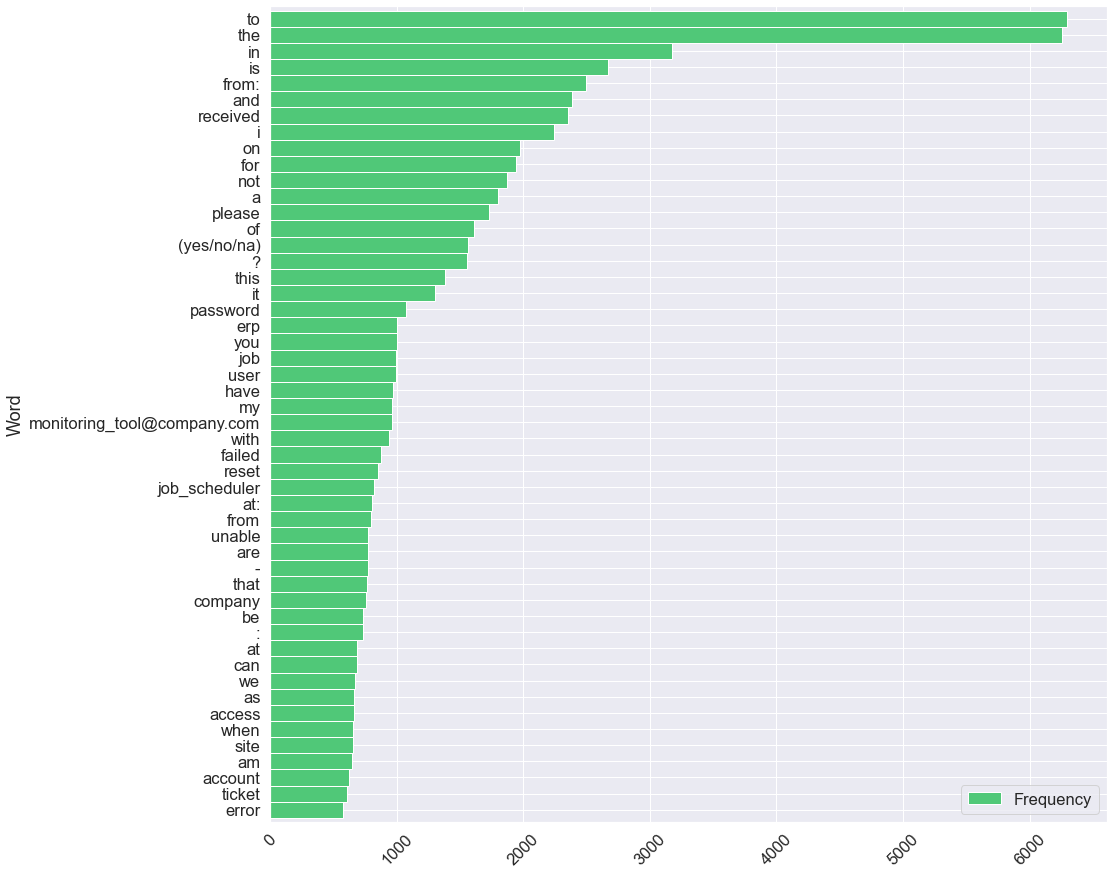

In [54]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [55]:
pprint(rslt.index.tolist(), compact=True)

['to', 'the', 'in', 'is', 'from:', 'and', 'received', 'i', 'on', 'for', 'not',
 'a', 'please', 'of', '(yes/no/na)', '?', 'this', 'it', 'password', 'erp',
 'you', 'job', 'user', 'have', 'my', 'monitoring_tool@company.com', 'with',
 'failed', 'reset', 'job_scheduler', 'at:', 'from', 'unable', 'are', '-',
 'that', 'company', 'be', ':', 'at', 'can', 'we', 'as', 'access', 'when',
 'site', 'am', 'account', 'ticket', 'error']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Stopwords and Anchor words like 'From:', 'Recieved' have to be stripped out
 </span></ul></h5>

In [56]:
# top 50 most frequent words in text
top_N = 50

words = (dataset.short_description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [57]:
rslt[:50].transpose()

Word         to    in  not  job   on   is  password  erp  failed  \
Frequency  2167  1737  981  976  917  856       847  822     822   

Word       job_scheduler  ...  with    i   my  crm  ticket  windows    /   am  \
Frequency            811  ...   193  191  187  185     182      177  177  168   

Word       password_management_tool  network  
Frequency                       161      155  

[1 rows x 50 columns]

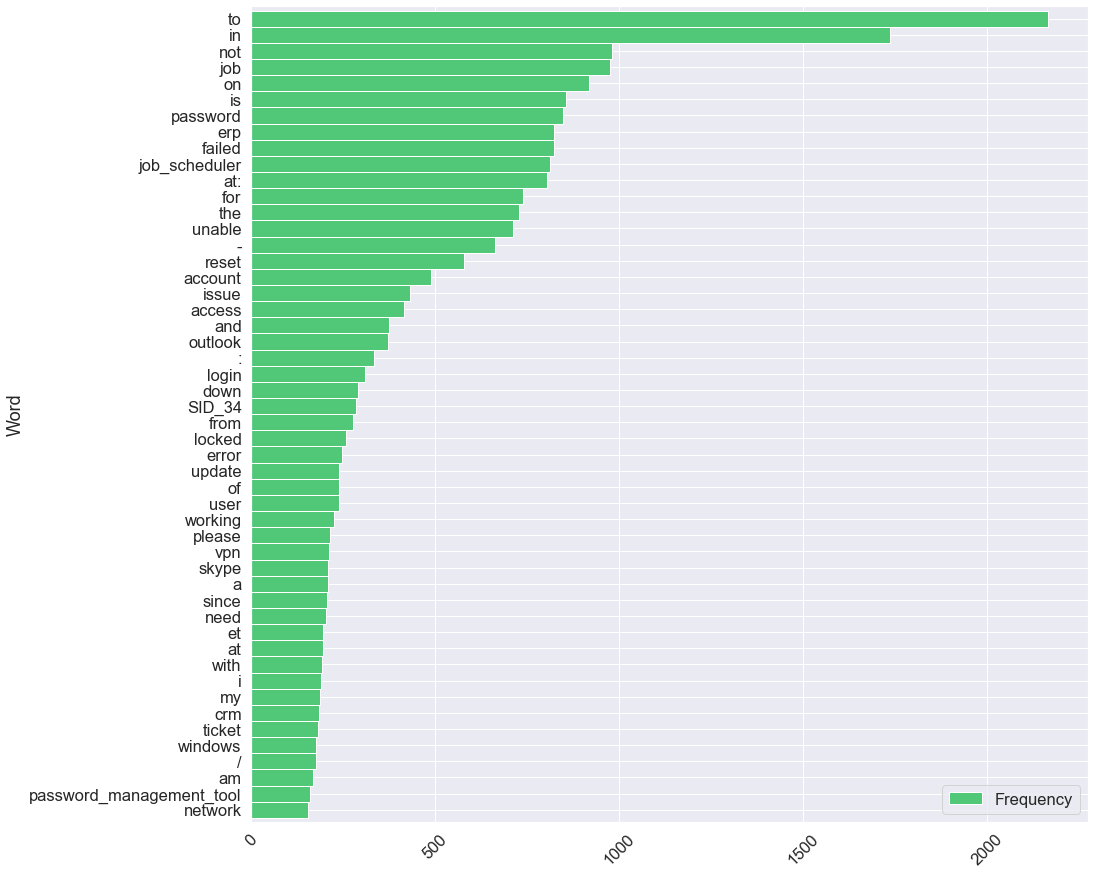

In [58]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [59]:
pprint(rslt.index.tolist(), compact=True)

['to', 'in', 'not', 'job', 'on', 'is', 'password', 'erp', 'failed',
 'job_scheduler', 'at:', 'for', 'the', 'unable', '-', 'reset', 'account',
 'issue', 'access', 'and', 'outlook', ':', 'login', 'down', 'SID_34', 'from',
 'locked', 'error', 'update', 'of', 'user', 'working', 'please', 'vpn', 'skype',
 'a', 'since', 'need', 'et', 'at', 'with', 'i', 'my', 'crm', 'ticket',
 'windows', '/', 'am', 'password_management_tool', 'network']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Many stopwords are occuring most frequently in the dataset. We might need to use stopword removal in our pre-processing if it improves the model performance.
 </span></ul></h5>

In [60]:
descr_string = ""
for description in dataset['description']:
    descr_string += description
    descr_string += " "

short_descr_string = ""
for description in dataset['short_description']:
    short_descr_string += description
    short_descr_string += " "

grp0_string = ""
for description in temp.loc[temp.group == 'Group 0', 'description']:
    grp0_string += description
    grp0_string += " "

other_string = ""
for description in temp.loc[temp.group == 'Other', 'description']:
    other_string += description
    other_string += " "

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Descriptions WordCloud</span></strong></li>
</ul></h4>

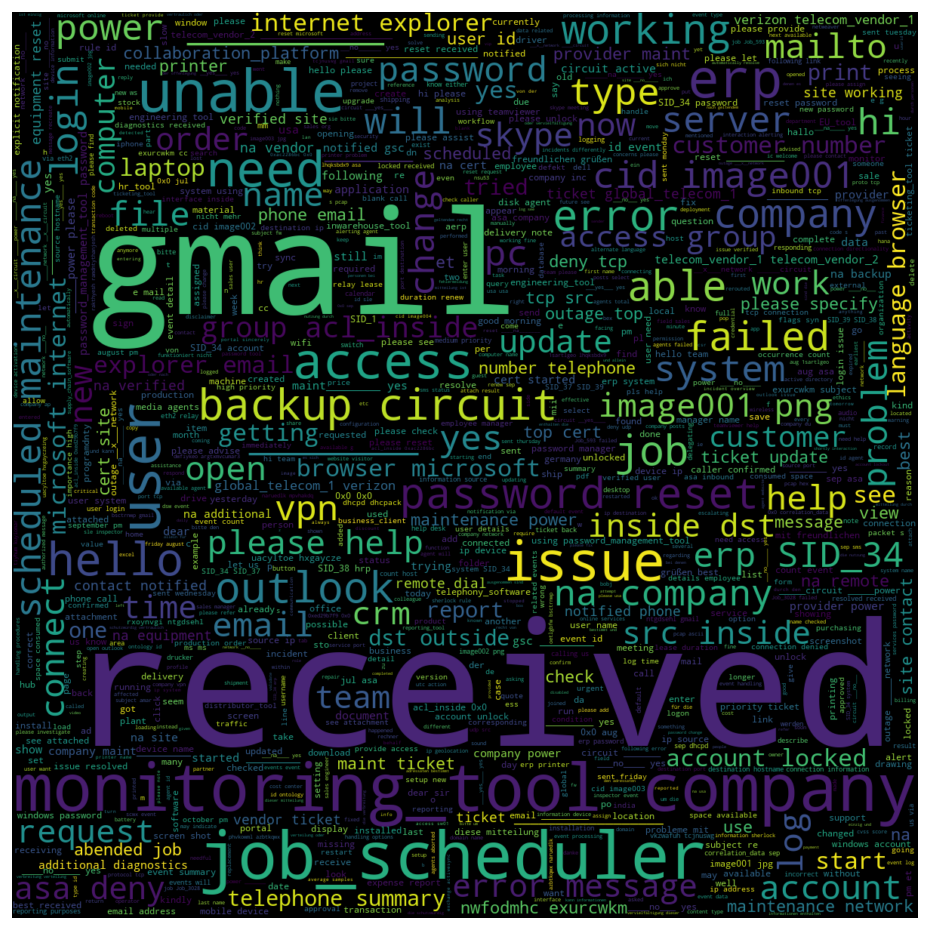

In [61]:
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Short Descriptions WordCloud</span></strong></li>
</ul></h4>

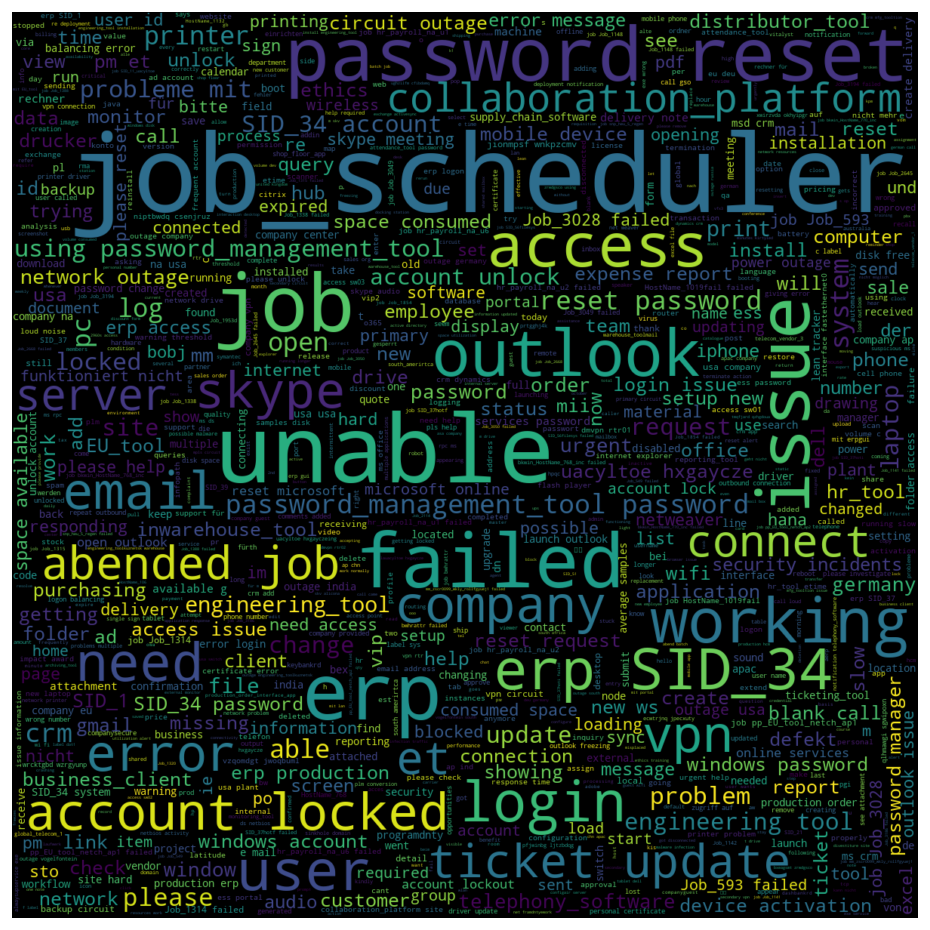

In [62]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(short_descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Group 0 Descriptions WordCloud</span></strong></li>
</ul></h4>

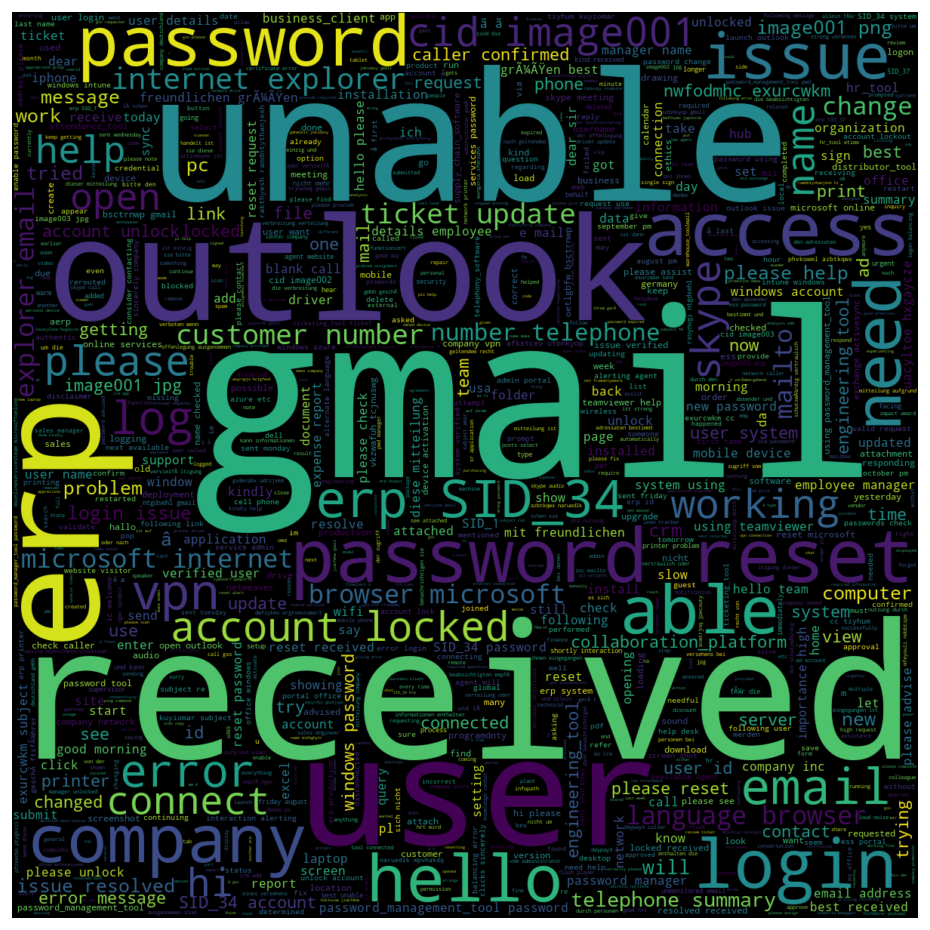

In [63]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(grp0_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Other Groups Descriptions WordCloud</span></strong></li>
</ul></h4>

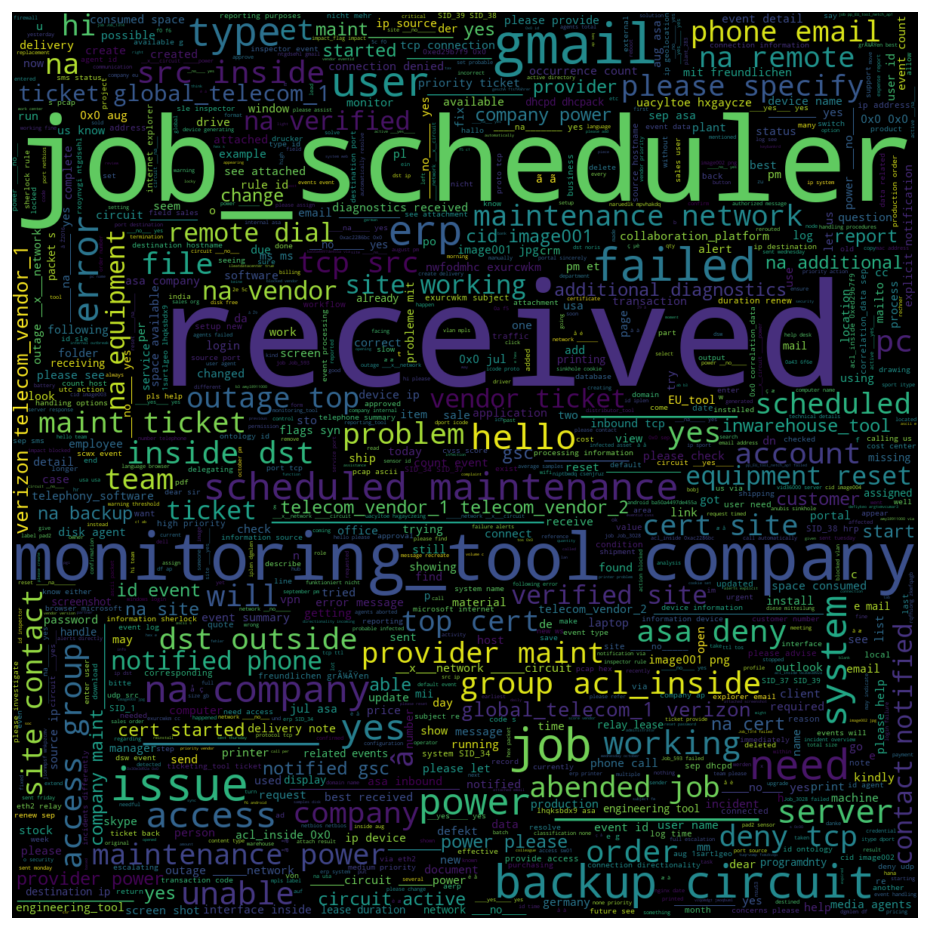

In [64]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(other_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Short Descriptions
 </span></ul></h4>

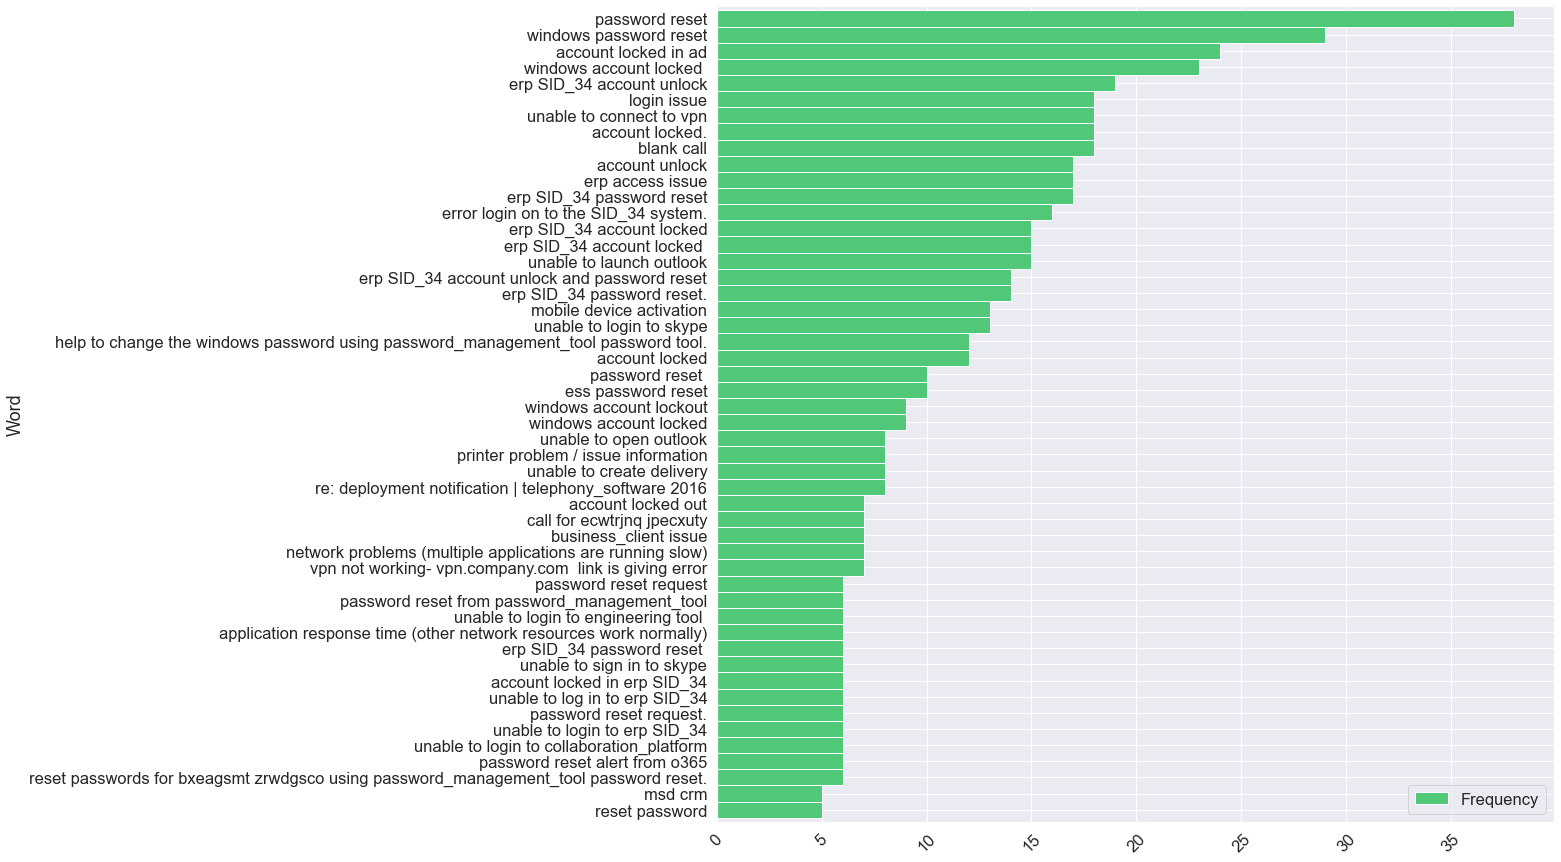

In [65]:
top_N = 50
rslt = pd.DataFrame(Counter(dataset.short_description.tolist()).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Descriptions
 </span></ul></h4>

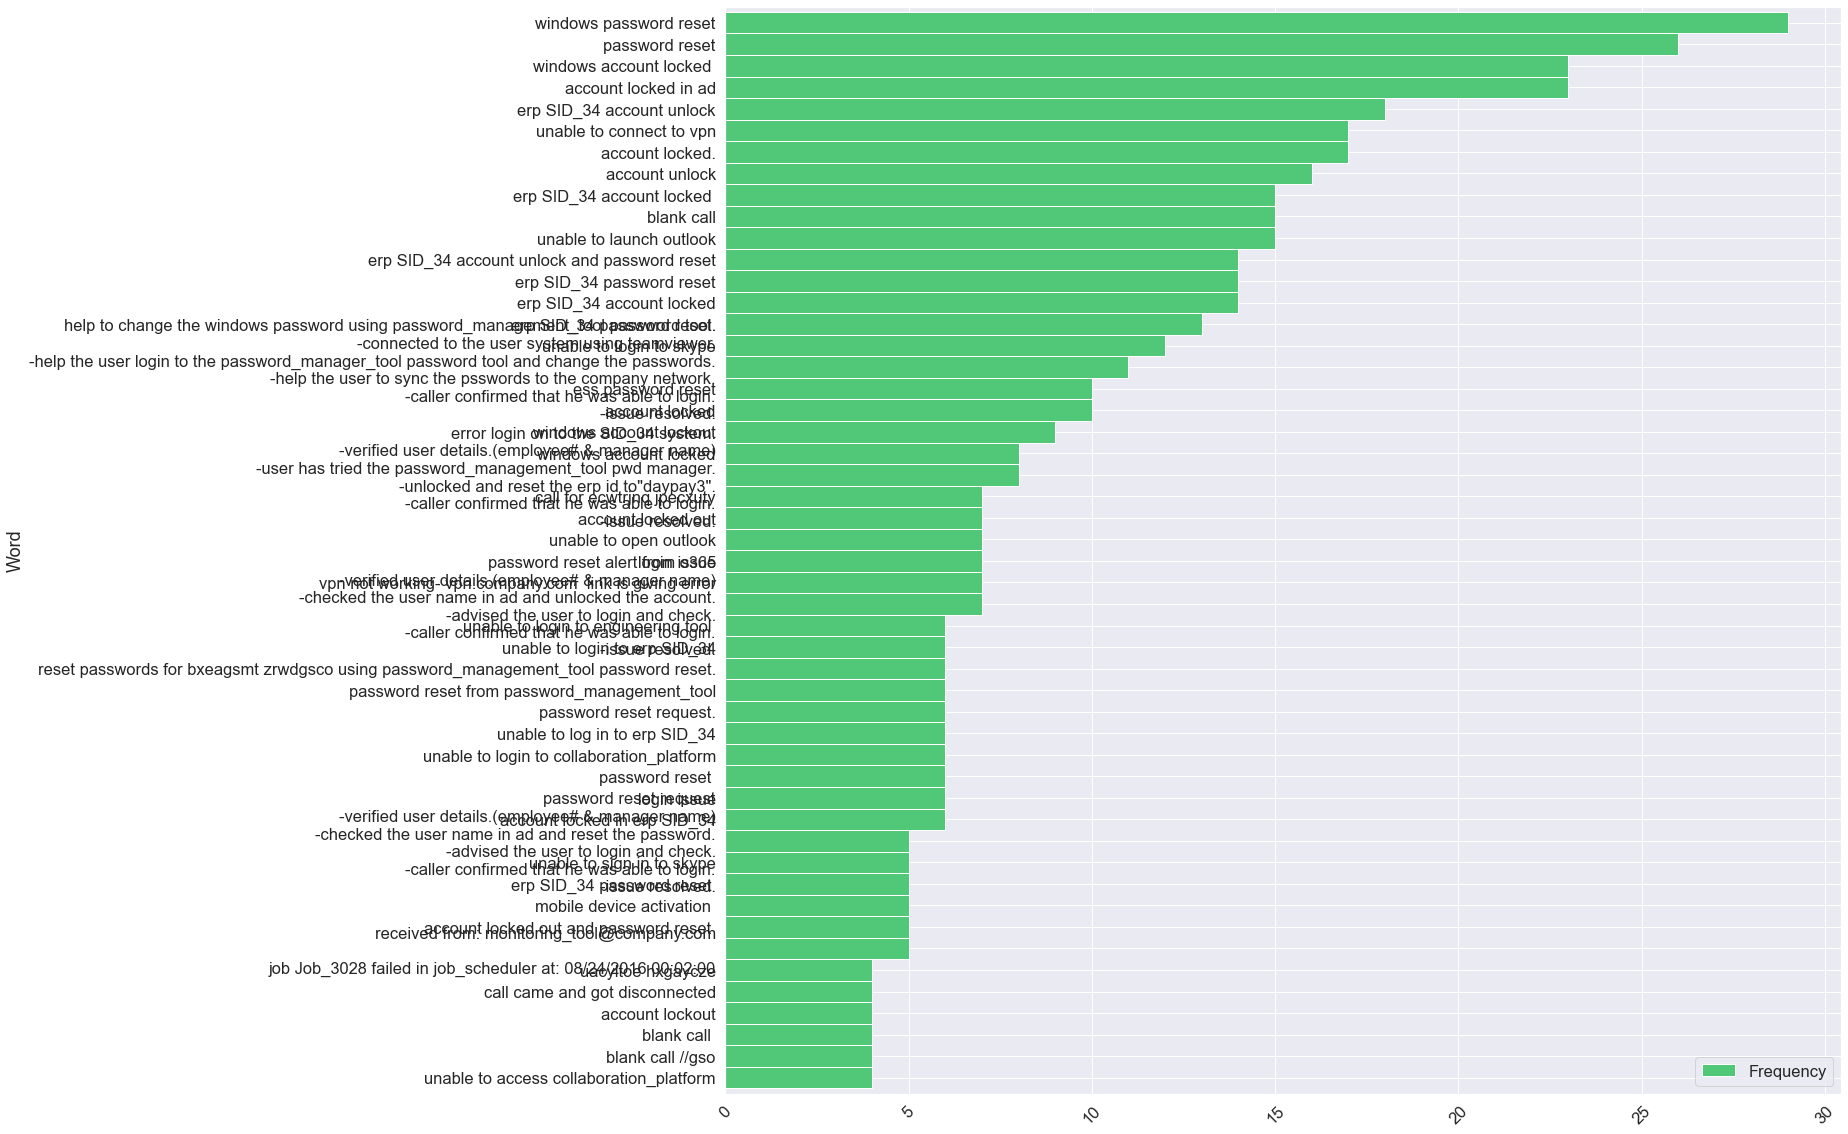

In [66]:
top_N = 50
rslt = pd.DataFrame(Counter(dataset.description.tolist()).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(20, 20), color='#50C878')
plt.xticks(rotation=45)
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Description Lengths vs. Functional Group</span></strong></li>
</ul></h3>

In [67]:
le = LabelEncoder()
dataset['group_code'] = le.fit_transform(dataset.group)
dataset.sample(7)

short_description  \
6600                              erp connections issue   
1592                                skype does not work   
3071  rechner ewew8323612 sehr langsam .\lxvunpiz mg...   
7938  user called to give information regarding tick...   
3344  request to reset microsoft online services pas...   
8181  shagfferon called to reset password for user :...   
5683  circuit outage:germany-1- (company):20 mbps li...   

                                            description             caller  \
6600                              erp connections issue  kslhobgj cyhvefna   
1592  skype will for load. phone . same problem as l...  otagsuzp xazhusry   
3071  rechner ewew8323612 sehr langsam .\lxvunpiz mg...  lxvunpiz mgjxwept   
7938  user called to give information regarding tick...  efbwiadp dicafxhv   
3344  from: microsoft on behalf of company inc. [mai...  dcaokyph vrdnocxs   
8181  shagfferon called to reset password for user :...  xpvluoni xeqjzofu   
5683  what type of outage:  _____network     __x___c...  oldrctiu bxurpsyi   

       group  char_length  word_length  short_char_length  short_word_length  \
6600   GRP_0           21            3                 21                  3   
1592   GRP_0           55           11                 19                  4   
3071  GRP_24           52            6                 52                  6   
7938   GRP_0           58            7                 58                  7   
3344   GRP_0         1059          149                 83                  9   
8181   GRP_0           54            8                 54                  8   
5683   GRP_4         1188          133                136                 20   

                     description_keywords  \
6600                erp connections issue   
1592                  skype will for load   
3071                         sehr langsam   
7938      user called to give information   
3344                                reset   
8181  shagfferon called to reset password   
5683                       type of outage   

                    short_description_keywords  group_code  
6600                     erp connections issue           0  
1592                       skype does not work           0  
3071                              sehr langsam          17  
7938           user called to give information           0  
3344  reset microsoft online services password           0  
8181       shagfferon called to reset password           0  
5683                       mbps link to global          34

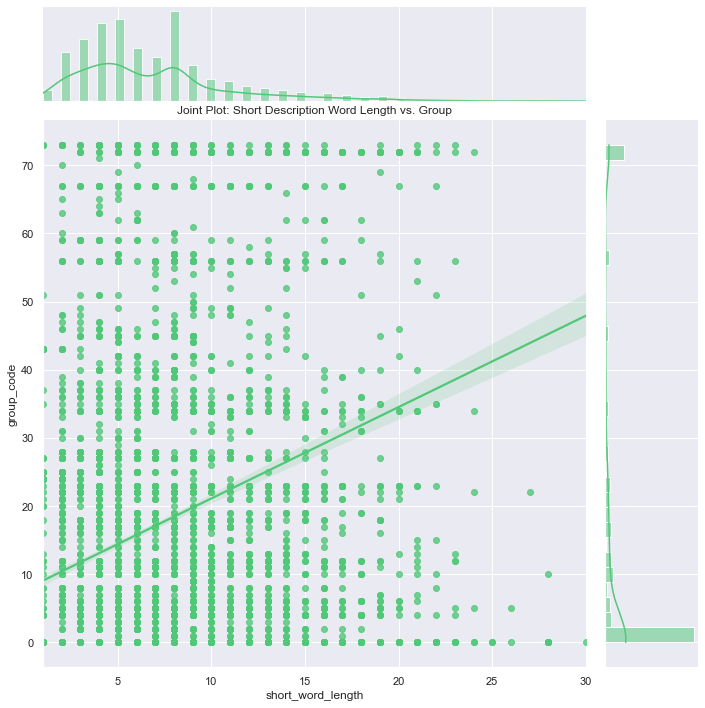

In [68]:
sns.set()
sns.jointplot(dataset.short_word_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Short Description Word Length vs. Group')
plt.show()

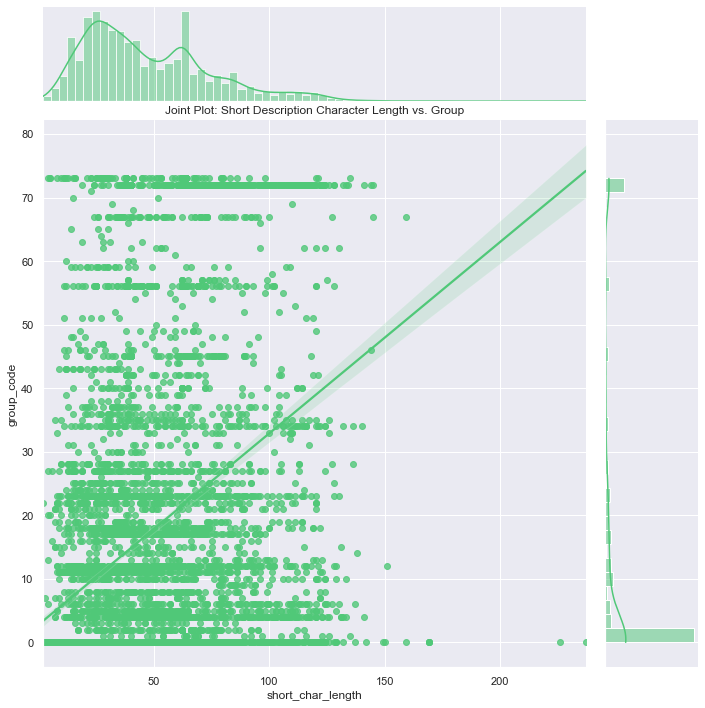

In [69]:
sns.set()
sns.jointplot(dataset.short_char_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Short Description Character Length vs. Group')
plt.show()

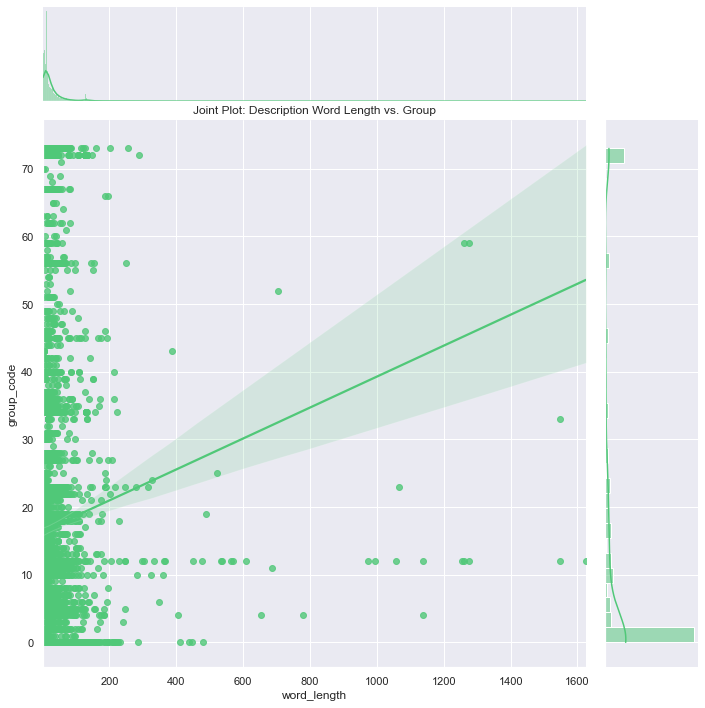

In [70]:
sns.set()
sns.jointplot(dataset.word_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Description Word Length vs. Group')
plt.show()

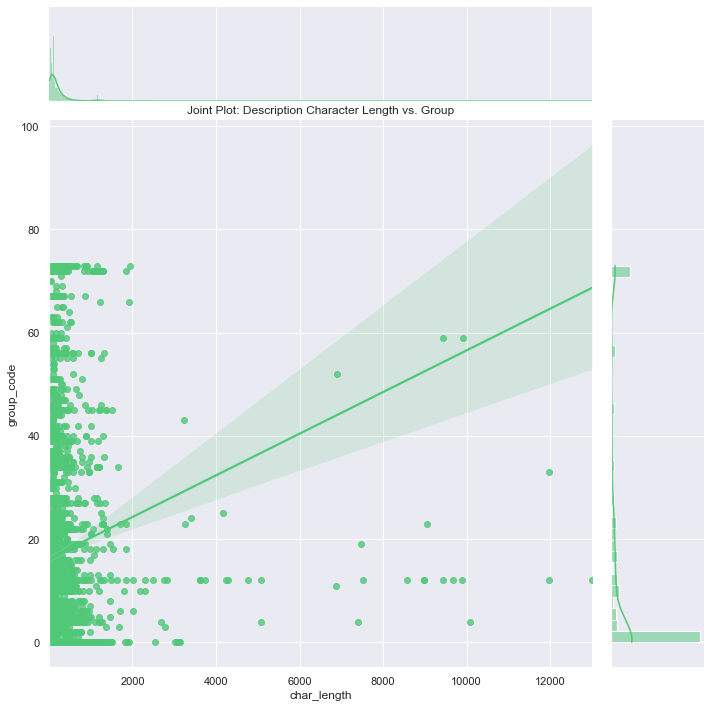

In [71]:
sns.set()
sns.jointplot(dataset.char_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Description Character Length vs. Group')
plt.show()

In [72]:
# binning the lengths

import jenkspy

NUM_BINS = 100
# calculates the natural breaks in a series, exploiting the Fisher-Jenks algorithm
# https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
breaks = jenkspy.jenks_breaks(dataset['char_length'], nb_class=NUM_BINS)
labels = list(range(len(breaks) - 1))
pprint(breaks, compact=True)

[3.0, 17.0, 23.0, 28.0, 34.0, 40.0, 47.0, 55.0, 63.0, 71.0, 80.0, 90.0, 101.0,
 109.0, 117.0, 126.0, 137.0, 149.0, 160.0, 170.0, 180.0, 190.0, 201.0, 213.0,
 224.0, 235.0, 247.0, 259.0, 271.0, 283.0, 295.0, 308.0, 323.0, 338.0, 354.0,
 372.0, 392.0, 412.0, 431.0, 449.0, 468.0, 486.0, 508.0, 537.0, 568.0, 596.0,
 620.0, 653.0, 684.0, 720.0, 765.0, 801.0, 837.0, 866.0, 908.0, 934.0, 990.0,
 1026.0, 1063.0, 1116.0, 1157.0, 1176.0, 1197.0, 1234.0, 1265.0, 1301.0, 1347.0,
 1398.0, 1478.0, 1526.0, 1692.0, 1877.0, 1952.0, 2013.0, 2172.0, 2293.0, 2548.0,
 2744.0, 2833.0, 3062.0, 3141.0, 3249.0, 3403.0, 3628.0, 3734.0, 4169.0, 4286.0,
 4766.0, 5087.0, 6887.0, 7403.0, 7524.0, 8575.0, 8991.0, 9063.0, 9440.0, 9678.0,
 9912.0, 10077.0, 11968.0, 13001.0]


In [73]:
dataset['char_length_bins'] = pd.cut(dataset['char_length'] ,bins=breaks, labels=labels, include_lowest=True)

In [74]:
dataset

short_description  \
0                                           login issue   
1                                               outlook   
2                                    cant log in to vpn   
3                         unable to access hr_tool page   
4                                          skype error    
...                                                 ...   
8495                  emails not coming in from zz mail   
8496                           telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498                       machine não está funcionando   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                            description             caller  \
0     -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                         unable to access hr_tool page  xbkucsvz gcpydteq   
4                                          skype error   owlgqjme qhcozdfx   
...                                                 ...                ...   
8495  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   
8496                           telephony_software issue  rbozivdq gmlhrtvp   
8497  vip2: windows password reset for tifpdchb pedx...  oybwdsgx oxyhwrfz   
8498  i am unable to access the machine utilities to...  ufawcgob aowhxjky   
8499  an mehreren pc`s lassen sich verschiedene prgr...  kqvbrspl jyzoklfx   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          206           33                 11                  2   
1      GRP_0          194           25                  7                  1   
2      GRP_0           87           11                 18                  5   
3      GRP_0           29            5                 29                  5   
4      GRP_0           12            2                 12                  2   
...      ...          ...          ...                ...                ...   
8495  GRP_29          141           19                 33                  7   
8496   GRP_0           24            2                 24                  2   
8497   GRP_0           50            7                 50                  7   
8498  GRP_62          103           17                 30                  4   
8499  GRP_49           82           11                 70                  9   

                             description_keywords  \
0                          verified user details.   
1                appearing in my outlook calendar   
2                                   log on to vpn   
3                                       tool page   
4                                     skype error   
...                                           ...   
8495                               good afternoon   
8496                               software issue   
8497          windows password reset for tifpdchb   
8498      finish the drawers adjustment settings.   
8499  sich verschiedene prgramdntyme nicht öffnen   

                       short_description_keywords  group_code char_length_bins  
0                                     login issue           0               22  
1                                         outlook           0               21  
2                                   log in to vpn           0               10  
3                                       tool page           0                3  
4                                     skype error           0                0  
...                                           ...         ...              ...  
8495                            emails not coming          22               16  
8496                               software issue           0                2  
8497          windows password reset for tifpdchb           0    

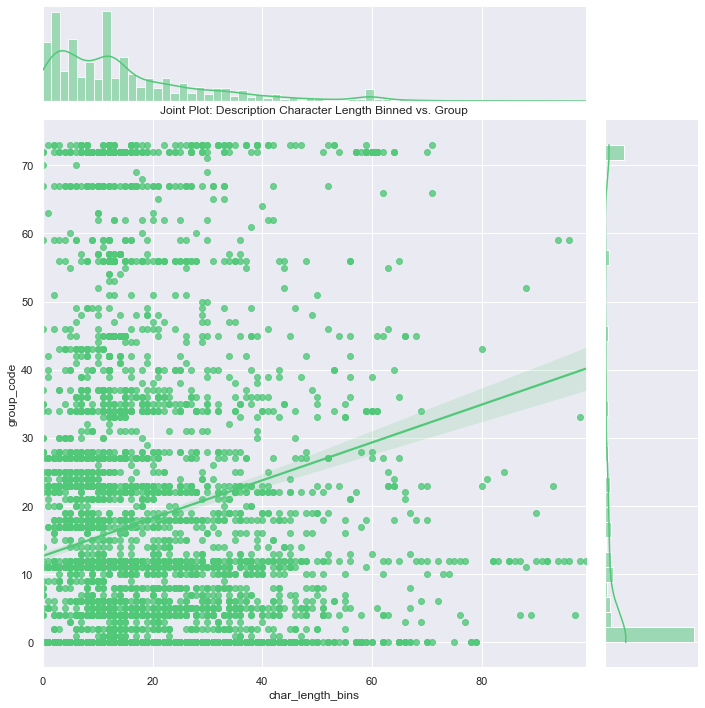

In [75]:
sns.set()
sns.jointplot(dataset.char_length_bins.astype(int), dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Description Character Length Binned vs. Group')
plt.show()

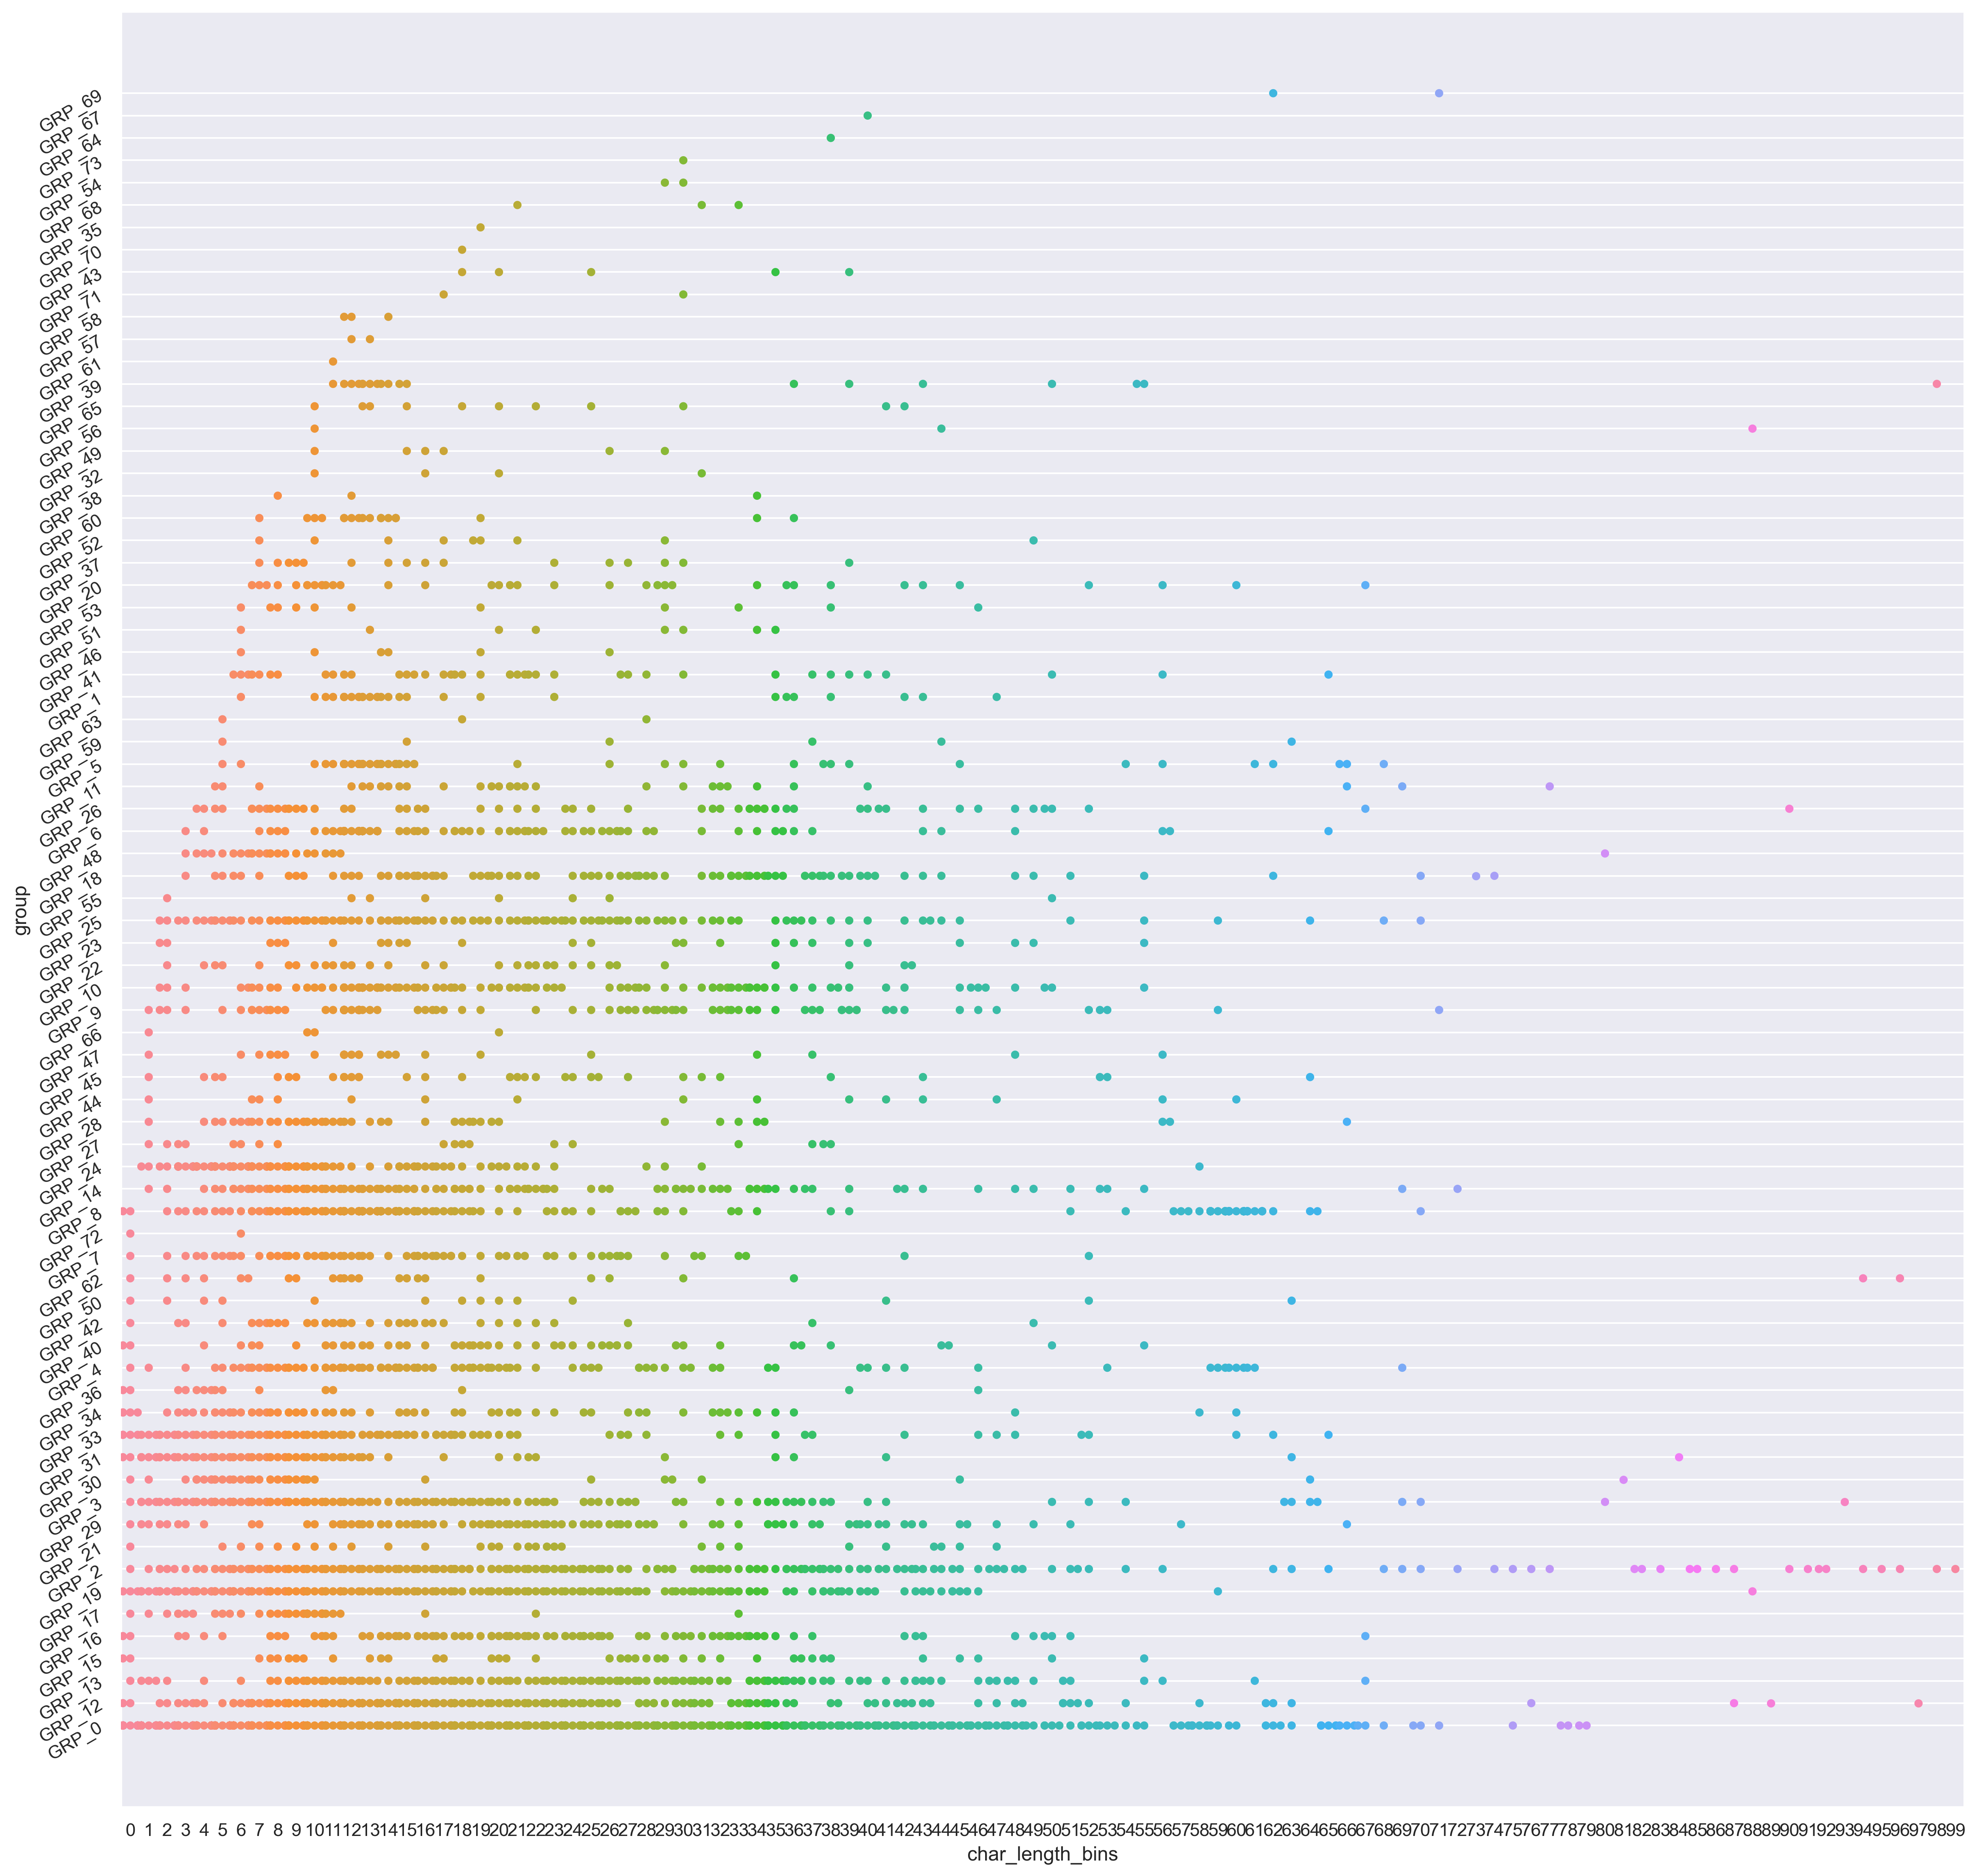

In [76]:
sns.set()
plt.figure(figsize=(20,20), dpi=300)
sns.swarmplot(x="char_length_bins", y="group", data=dataset)
plt.yticks(rotation=30)
plt.show()

In [77]:
# TODO: perform Chi2 Test with group to decide whether to include length features
# If so, fine-tune the number of bins

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Language Detection</span></strong></li>
</ul></h3>

In [78]:
# detect the languages in the dataset
languages = []
errs = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 74%|████████████████████████████████████████████████████████▉                    | 6280/8499 [00:42<00:14, 150.19it/s]

text:  +86  
No features in text.


100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:56<00:00, 151.35it/s]


In [79]:
print("Unique languages in the descriptions: "
      f"{np.unique(languages)}")

Unique languages in the descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'id' 'it'
 'ko' 'lt' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq' 'sv' 'sw' 'tl'
 'tr' 'vi' 'zh-cn']


In [80]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                      columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language     en  no   fr   it  es   af  ca  sv  nl  ro  ...  hr  pt  so  sk  \
Frequency  7012  65  110  146  56  264  46  56  67  20  ...   6  17   4   1   

Language   tr  sw  vi  lt  fi  cs  
Frequency   1   1   3   2   6   1  

[1 rows x 31 columns]

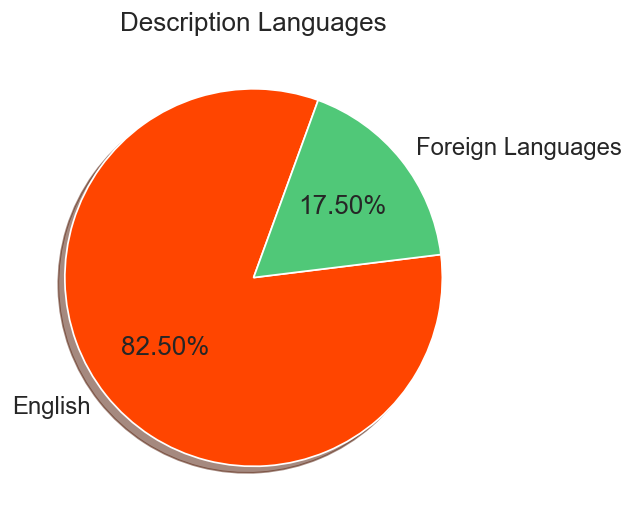

In [81]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
eng = freq_df.loc['en'].tolist()[0]
foreign_lang = len(dataset) - freq_df.loc['en'].tolist()[0]

plt.pie(x=[eng, foreign_lang],
        explode=(0, 0),
        labels=['English', 'Foreign Languages'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Description Languages')
plt.show()

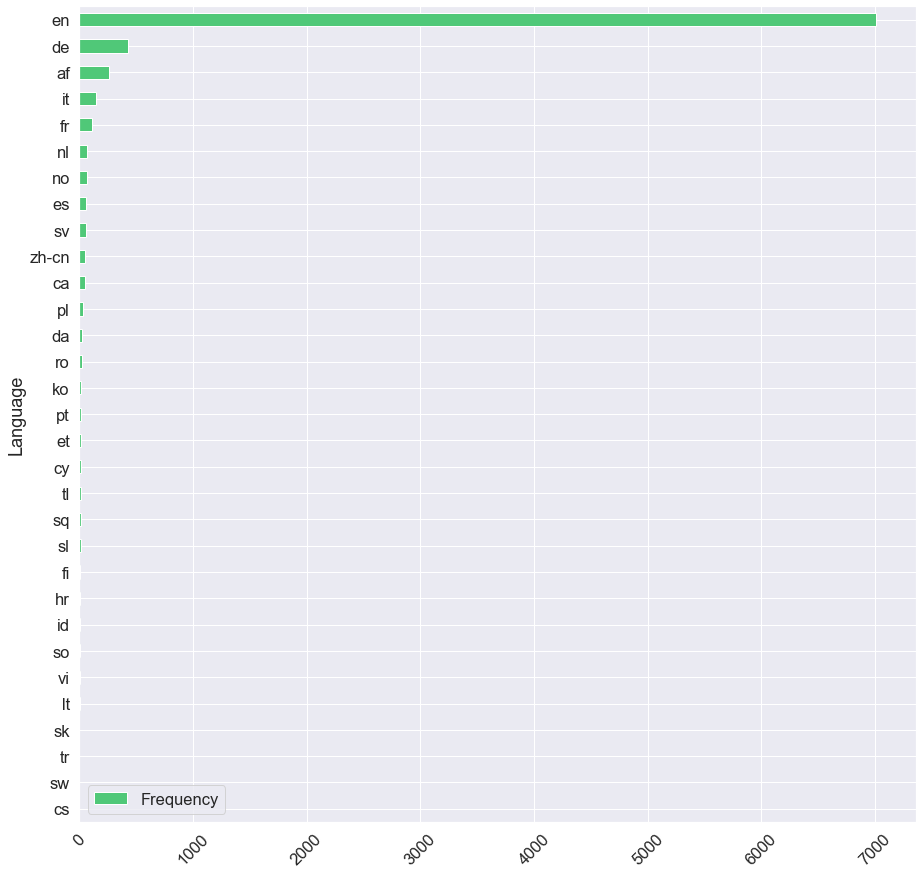

In [82]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [83]:
# for i in lang_samples:
#     print(i)
#     try:
#         print(random.sample(lang_samples[i], 3))
#     except Exception:
#         print(random.sample(lang_samples[i], 1))
#     print('')

In [84]:
# detect the languages in the dataset
languages = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.short_description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 22%|████████████████▊                                                            | 1851/8499 [00:15<00:58, 113.08it/s]

text:  bgflmyar.xgufkidq@gmail.com
No features in text.


 35%|███████████████████████████▏                                                 | 2994/8499 [00:25<00:47, 116.37it/s]

text:  ???????????????????
No features in text.


100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [01:12<00:00, 117.70it/s]


In [85]:
print("Unique languages in the short descriptions: "
      f"{np.unique(languages)}")

Unique languages in the short descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'id' 'it'
 'ko' 'lt' 'lv' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq' 'sv' 'sw'
 'tl' 'vi' 'zh-cn']


In [86]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                       columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language    it  et    en   no  es   nl   af   ca  sv  ro  ...  sk  tl  sq  vi  \
Frequency  274  26  6017  156  84  150  498  105  85  45  ...  12  23  13  10   

Language   hr  ko  so  sw  lt  lv  
Frequency   6  16   6   1   5   3  

[1 rows x 31 columns]

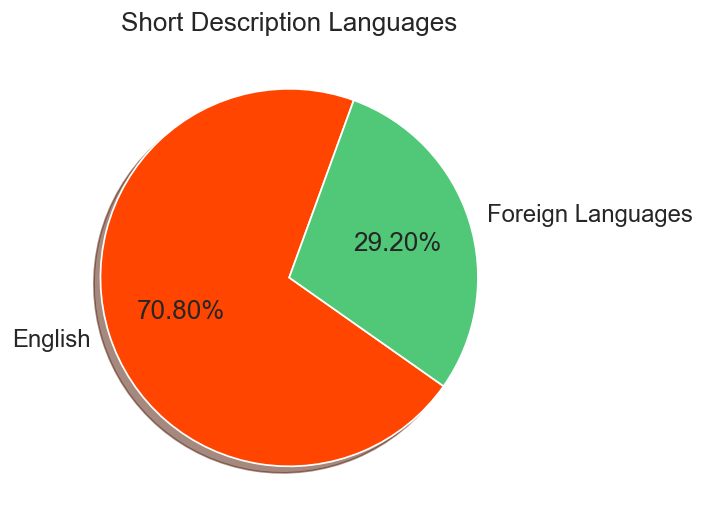

In [87]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
eng = freq_df.loc['en'].tolist()[0]
foreign_lang = len(dataset) - freq_df.loc['en'].tolist()[0]

plt.pie(x=[eng, foreign_lang],
        explode=(0, 0),
        labels=['English', 'Foreign Languages'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Short Description Languages')
plt.show()

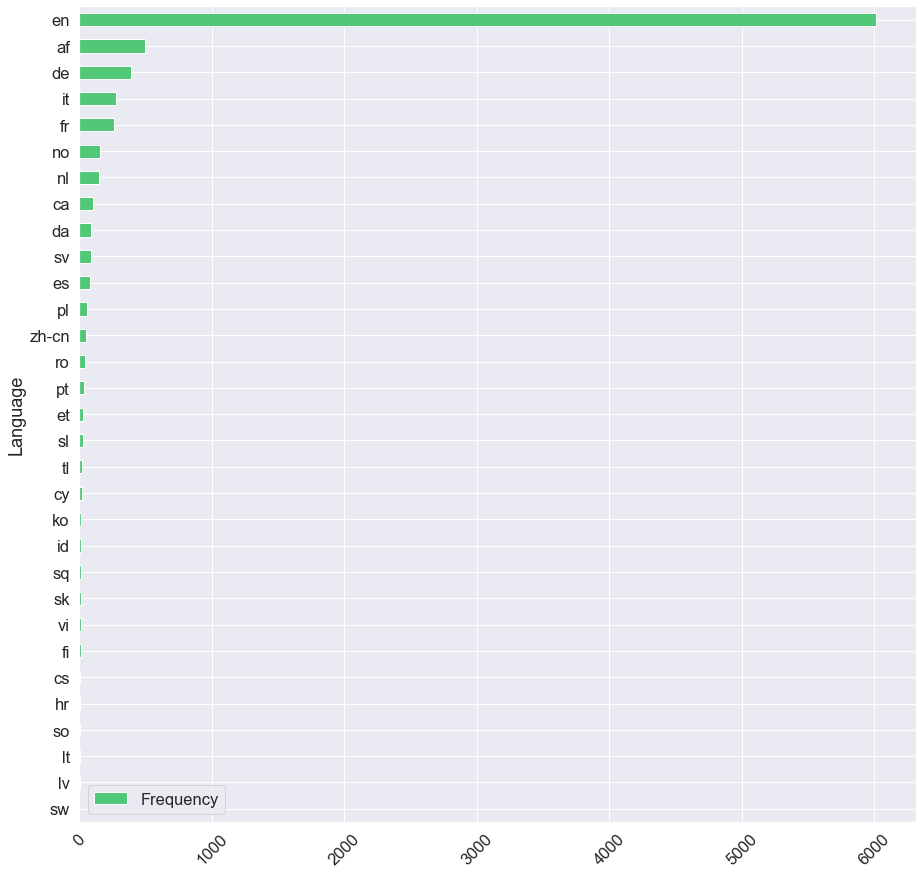

In [88]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [89]:
# for i in lang_samples:
#     print(i)
#     try:
#         print(random.sample(lang_samples[i], 3))
#     except Exception:
#         print(random.sample(lang_samples[i], 1))
#     print('')

In [90]:
errs  # few errors where lang_detect failed, need to impute these irrelevant values

['+86  ', 'bgflmyar.xgufkidq@gmail.com', '???????????????????']

In [91]:
dataset[dataset.description == errs[0]]

short_description description  \
6253  in the inbox always show there are several ema...       +86     

                 caller  group  char_length  word_length  short_char_length  \
6253  mqbxwpfn uclrqfxa  GRP_0            5            1                 94   

      short_word_length description_keywords short_description_keywords  \
6253                 19                               inbox always show   

      group_code char_length_bins  
6253           0                0

In [92]:
dataset.loc[dataset.description == errs[0], 'description'] = dataset[dataset.description == errs[0]].short_description

In [93]:
dataset[dataset.short_description == errs[1]]

short_description  \
1836  bgflmyar.xgufkidq@gmail.com   

                                            description             caller  \
1836  bgflmyar.xgufkidq@gmail.com wanted to check if...  olckhmvx pcqobjnd   

      group  char_length  word_length  short_char_length  short_word_length  \
1836  GRP_0           83           13                 27                  1   

     description_keywords short_description_keywords  group_code  \
1836    tool on his phone                                      0   

     char_length_bins  
1836               10

In [94]:
dataset.loc[dataset.short_description == errs[1], 'short_description'] = dataset[dataset.short_description == errs[1]].description

In [95]:
dataset[dataset.short_description == errs[2]]

short_description                                        description  \
2975  ???????????????????  \n\nreceived from: yzbjhmpw.vzrulkog@gmail.com...   

                 caller  group  char_length  word_length  short_char_length  \
2975  yzbjhmpw vzrulkog  GRP_0         1207          131                 19   

      short_word_length                          description_keywords  \
2975                  1  company shared services gmbh geschäftsführer   

     short_description_keywords  group_code char_length_bins  
2975                                      0               62

In [96]:
dataset.loc[dataset.short_description == errs[2], 'short_description'] = dataset[dataset.short_description == errs[2]].description

<h2><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Pre-Processing</span></strong></li>
</ul></h2>

In [97]:
dataset

short_description  \
0                                           login issue   
1                                               outlook   
2                                    cant log in to vpn   
3                         unable to access hr_tool page   
4                                          skype error    
...                                                 ...   
8495                  emails not coming in from zz mail   
8496                           telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498                       machine não está funcionando   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                            description             caller  \
0     -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                         unable to access hr_tool page  xbkucsvz gcpydteq   
4                                          skype error   owlgqjme qhcozdfx   
...                                                 ...                ...   
8495  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   
8496                           telephony_software issue  rbozivdq gmlhrtvp   
8497  vip2: windows password reset for tifpdchb pedx...  oybwdsgx oxyhwrfz   
8498  i am unable to access the machine utilities to...  ufawcgob aowhxjky   
8499  an mehreren pc`s lassen sich verschiedene prgr...  kqvbrspl jyzoklfx   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          206           33                 11                  2   
1      GRP_0          194           25                  7                  1   
2      GRP_0           87           11                 18                  5   
3      GRP_0           29            5                 29                  5   
4      GRP_0           12            2                 12                  2   
...      ...          ...          ...                ...                ...   
8495  GRP_29          141           19                 33                  7   
8496   GRP_0           24            2                 24                  2   
8497   GRP_0           50            7                 50                  7   
8498  GRP_62          103           17                 30                  4   
8499  GRP_49           82           11                 70                  9   

                             description_keywords  \
0                          verified user details.   
1                appearing in my outlook calendar   
2                                   log on to vpn   
3                                       tool page   
4                                     skype error   
...                                           ...   
8495                               good afternoon   
8496                               software issue   
8497          windows password reset for tifpdchb   
8498      finish the drawers adjustment settings.   
8499  sich verschiedene prgramdntyme nicht öffnen   

                       short_description_keywords  group_code char_length_bins  
0                                     login issue           0               22  
1                                         outlook           0               21  
2                                   log in to vpn           0               10  
3                                       tool page           0                3  
4                                     skype error           0                0  
...                                           ...         ...              ...  
8495                            emails not coming          22               16  
8496                               software issue           0                2  
8497          windows password reset for tifpdchb           0    

### Pipeline
* fix text encoding usng ftfy.fix_text
* handle other languages (drop or translate) (TODO)
* parse email messages to retain only subject and body
* clean up emails, links, website links, telephone numbers
* clean up anchor words like: 'Received from:', 'name:', 'hello', 'hello team' , 'cid' ...
* clean up security logs (TODO)
* clean up outage questionnaires (TODO)
* clean html tags if they exist
* clean /r /n characters
* strip caller names in descriptions
* translate accented characters (á -> a)
* convert unicode characters to ascii
* expand contractions (they're -> they are)
* clean stopwords & any custom stopwords
* clean up extra whitespaces & tokenize
* remove gibberish (after language translation)
* strip extra punctuation
* lemmatization/stemming (if needed for a model)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">TODO: Language Translation</span></strong></li>
</ul></h3>

In [98]:
# from charset_normalizer import from_bytes, detect

# temp = set()
# for descr in tqdm(dataset.short_description.tolist()):
#     detection = detect(descr.encode('utf-8'))
#     if detection['language'] != 'English':
#         # print(detection)
#         # print(description)
#         temp.update([descr])
#         # print('~'*100)
# len(temp)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">TODO: Outage Questionnaires</span></strong></li>
</ul></h3>

In [99]:
outage_df = dataset.reset_index().loc[pd.Series(['outage' in i for i in  dataset.description.tolist()])]

In [100]:
outage_df.group.value_counts()

GRP_8     139
GRP_4      16
GRP_0       8
GRP_16      1
Name: group, dtype: int64

In [101]:
outage_df

index                                  short_description  \
78       78  power outage:UK al, 1st and 5th ave sites hard...   
79       79  power outage : germany, mx: site is hard down ...   
189     189  network outage: india: site hard down since at...   
215     215  network outage  - warehouse: node company-ups-...   
240     240  power outage :australia australia: site hard d...   
...     ...                                                ...   
8097   8098  network outage, russia ru, company-russia-vpn-...   
8184   8185  circuit outage: vogelfontein, south africa mpl...   
8272   8273  network outage : south amerirtca(argentina) si...   
8274   8275  network outage: usa site is hard down since 05...   
8315   8316  network outage: sao pollaurido-mercedes benz p...   

                                            description             caller  \
78    what type of outage:  _____network     _____ci...  mnlazfsr mtqrkhnx   
79    what type of outage:  ___x__network     _____c...  jyoqwxhz clhxsoqy   
189   what type of outage:  __x___network     _____c...  mnlazfsr mtqrkhnx   
215   what type of outage:  __x___network     _____c...  jyoqwxhz clhxsoqy   
240   what type of outage:  __x___network     _____c...  utyeofsk rdyzpwhi   
...                                                 ...                ...   
8097  what type of outage:  _x____network     _____c...  uxgrdjfc kqxdjeov   
8184  what type of outage:  _____network     ___x__c...  jyoqwxhz clhxsoqy   
8272  what type of outage:  ____x_network     _____c...  vbwszcqn nlbqsuyv   
8274  what type of outage:  _x____network     _____c...  vbwszcqn nlbqsuyv   
8315  what type of outage:  __x___network     _____c...  dkmcfreg anwmfvlg   

      group  char_length  word_length  short_char_length  short_word_length  \
78    GRP_8         1197          132                 82                 17   
79    GRP_8         1156          129                 74                 14   
189   GRP_8         1163          130                 86                 16   
215   GRP_8         1152          128                 80                 11   
240   GRP_8         1167          132                 78                 13   
...     ...          ...          ...                ...                ...   
8097  GRP_8         1172          130                123                 16   
8184  GRP_8         1158          130                 86                 15   
8272  GRP_8         1148          129                 88                 14   
8274  GRP_8         1152          130                 65                 13   
8315  GRP_8         1188          130                113                 17   

     description_keywords                  short_description_keywords  \
78         type of outage                              ave sites hard   
79         type of outage                                power outage   
189        type of outage                              network outage   
215        type of outage                              network outage   
240        type of outage                                power outage   
...                   ...                                         ...   
8097       type of outage                              network outage   
8184       type of outage                   south africa mpls circuit   
8272       type of outage                              network outage   
8274       type of outage                            usa site is hard   
8315       type of outage  sao pollaurido-mercedes benz plant network   

      group_code char_length_bins  
78            72               61  
79            72               59  
189           72               60  
215           72               59  
240           72               60  
...          ...              ...  
8097          72               60  
8184          72               60  
8272          72               59  
8274          72               59  
8315          72               61  

[164 rows x 13 co

In [102]:
outage_df.group.value_counts()

GRP_8     139
GRP_4      16
GRP_0       8
GRP_16      1
Name: group, dtype: int64

In [103]:
print(outage_df.description.tolist()[0])

what type of outage:  _____network     _____circuit     ___x__power (please specify what type of outage)

1. top 23 cert site   ?    ___yes______     (yes/no/na) 

2. when did it start  ?   ________4:31 pm et on 10/30. _____________

3.  scheduled maintenance ( power) ? __yno_____    (yes/no/na)     company power  _________     provider power _________
                
4.  scheduled maintenance ( network) ? ___no____    (yes/no/na)     company maint________ (yes/no)       provider maint/ticket #__________________    

5. does site have a backup circuit ?  __yes____    (yes/no/na) 

6. backup circuit active ?   ___na_____     (yes/no/na) 

7. site contact notified (phone/email) ?  _________     (yes/no/na) 

8. remote dial-in ?   ____na_______   (yes/no/na) 

9. equipment reset ?    ____na_______    (yes/no/na) 

10. verified site working on backup circuit ?  ___na____     (yes/no/na) 

11. vendor ticket  # ( global_telecom_1, verizon, telecom_vendor_1, telecom_vendor_2 )    ____global_

In [104]:
outage_df

index                                  short_description  \
78       78  power outage:UK al, 1st and 5th ave sites hard...   
79       79  power outage : germany, mx: site is hard down ...   
189     189  network outage: india: site hard down since at...   
215     215  network outage  - warehouse: node company-ups-...   
240     240  power outage :australia australia: site hard d...   
...     ...                                                ...   
8097   8098  network outage, russia ru, company-russia-vpn-...   
8184   8185  circuit outage: vogelfontein, south africa mpl...   
8272   8273  network outage : south amerirtca(argentina) si...   
8274   8275  network outage: usa site is hard down since 05...   
8315   8316  network outage: sao pollaurido-mercedes benz p...   

                                            description             caller  \
78    what type of outage:  _____network     _____ci...  mnlazfsr mtqrkhnx   
79    what type of outage:  ___x__network     _____c...  jyoqwxhz clhxsoqy   
189   what type of outage:  __x___network     _____c...  mnlazfsr mtqrkhnx   
215   what type of outage:  __x___network     _____c...  jyoqwxhz clhxsoqy   
240   what type of outage:  __x___network     _____c...  utyeofsk rdyzpwhi   
...                                                 ...                ...   
8097  what type of outage:  _x____network     _____c...  uxgrdjfc kqxdjeov   
8184  what type of outage:  _____network     ___x__c...  jyoqwxhz clhxsoqy   
8272  what type of outage:  ____x_network     _____c...  vbwszcqn nlbqsuyv   
8274  what type of outage:  _x____network     _____c...  vbwszcqn nlbqsuyv   
8315  what type of outage:  __x___network     _____c...  dkmcfreg anwmfvlg   

      group  char_length  word_length  short_char_length  short_word_length  \
78    GRP_8         1197          132                 82                 17   
79    GRP_8         1156          129                 74                 14   
189   GRP_8         1163          130                 86                 16   
215   GRP_8         1152          128                 80                 11   
240   GRP_8         1167          132                 78                 13   
...     ...          ...          ...                ...                ...   
8097  GRP_8         1172          130                123                 16   
8184  GRP_8         1158          130                 86                 15   
8272  GRP_8         1148          129                 88                 14   
8274  GRP_8         1152          130                 65                 13   
8315  GRP_8         1188          130                113                 17   

     description_keywords                  short_description_keywords  \
78         type of outage                              ave sites hard   
79         type of outage                                power outage   
189        type of outage                              network outage   
215        type of outage                              network outage   
240        type of outage                                power outage   
...                   ...                                         ...   
8097       type of outage                              network outage   
8184       type of outage                   south africa mpls circuit   
8272       type of outage                              network outage   
8274       type of outage                            usa site is hard   
8315       type of outage  sao pollaurido-mercedes benz plant network   

      group_code char_length_bins  
78            72               61  
79            72               59  
189           72               60  
215           72               59  
240           72               60  
...          ...              ...  
8097          72               60  
8184          72               60  
8272          72               59  
8274          72               59  
8315          72               61  

[164 rows x 13 co

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">TODO: Security/Event Logs</span></strong></li>
</ul></h3>

In [105]:
dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])]  # all security incident logs

index                                  short_description  \
341     341  security incidents - ( #in33071122 ) :[ipbl]: ...   
2977   2978  security incidents - ( #in33987594) : 29866 vi...   
3096   3097  security incidents - ( #in33976733) : suspicio...   
3097   3098  security incidents - ( #in33984033) : internal...   
3529   3530  security incidents - ( #in33944691 ) : possibl...   
3531   3532  security incidents - ( #in33944327) :possible ...   
3704   3705  security incidents - ( #in33932723 ) : possibl...   
3705   3706  security incidents - ( #in33924718 ) : possibl...   
3960   3961  security incidents - ( #in33805815) : possible...   
3964   3965  security incidents - ( #in33809307 ) : possibl...   
4086   4087  security incidents - ( sw #in33895560 ) : mage...   
4088   4089  security incidents - ( sw #in33895560 ) : mage...   
4729   4730  security incidents - (  #in33847938) : possibl...   
4824   4825   incident #in33541962 - phishing form submit -...   
4885   4886  security incidents - ( #in33826812 ) : possibl...   
4892   4893  security incidents - ( #in33826812 ) : possibl...   
5091   5092  security incidents - ( #in33578632) : suspicio...   
5432   5433  security incidents - ( #in33765965 ) : possibl...   
5503   5504   incident #in33541962 - phishing form submit -...   
5505   5506                                     dsw in22457494   
5506   5507  possible vulnerability scan from host.my-tss.c...   
6063   6064  engineering_tool installation issue for distri...   
6733   6734  security incidents - ( dsw incident no ) : sus...   
6749   6750  security incidents - ( #in33669678 ) : possibl...   
6887   6888  security incidents - (#in33655554) : errata se...   
6930   6931  '51551 vid67965 microsoft windows httpsys rce ...   
6936   6937   [hw] filesystem near capacity - h:(HostName_894)   
7080   7081           possible bash command injection attempt    
7150   7151  security incidents - ( in33426117 ) : correlat...   
7153   7154  security incidents - ( #in33417637 ) : repeat ...   
7330   7331  security incidents - ( #in33505432 ) : repeat ...   
7337   7338  security incidents - ( #in33505432 ) : repeat ...   
7344   7345  security incidents - ( sw #in33501789 ) : broa...   
7347   7348                HostName_480 - verify filesystem h:   
7351   7352      event summary: [hw] service icmp/icmp is down   
7353   7354      event summary: [hw] service icmp/icmp is down   
7354   7355      event summary: [hw] service icmp/icmp is down   
7355   7356                    HostName_68 near capacity - 90%   
7646   7647  security incidents - ( #in33578632) : suspicio...   
7981   7982  security incidents - ( dsw #in33390850 ) : sus...   
7983   7984  security incidents - ( dsw #in33390850 ) : sus...   
7986   7987  security incidents - (in33536629) : possible t...   
7988   7989  security incidents - ( dsw #in33407676 ) : tra...   
7990   7991  as per inc1530161::security incidents - ( in33...   
7994   7995  security incidents - ( dsw #in33407676 ) : tra...   
7995   7996  security incidents - ( in33490582 ) : suspicio...   
7996   7997  security incidents - ( sw #in33544563 ) : poss...   
8001   8002  security incidents - ( sw #in33544563 ) : poss...   

                                            description             caller  \
341   source ip :\nsystem name :lmsl9516338\nuser  n...  gzhapcld fdigznbk   
2977  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3096  source ip: 10.16.90.249\nsource hostname: andr...  gzhapcld fdigznbk   
3097  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3529  source ip: 195.272.28.222\nsource port: 80\nso...  gzhapcld fdigznbk   
3531  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3704  source ip: 10.44.63.52\nsource hostname: leeng...  gzhapcld fdigznbk   
3705  source ip :195.22.28.222\ndestination ip: 12.9...  gzhapcld fdigznbk   
3960  =========================\nevent data\n=======...  gzhapcld fdi

In [106]:
dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])].group.value_counts()  # groups

GRP_2     26
GRP_39     4
GRP_3      4
GRP_12     4
GRP_62     2
GRP_56     1
GRP_0      1
GRP_31     1
GRP_69     1
GRP_19     1
GRP_30     1
GRP_48     1
GRP_47     1
Name: group, dtype: int64

In [107]:
dataset.reset_index().loc[pd.Series(['cyber' in i for i in  dataset.short_description.tolist()])]

index                                  short_description  \
491     491          october cyber security month - ransomware   
1729   1729  cyber security - phish uacyltoe hxgaycze repor...   
5411   5412  cyber security - phish uacyltoe hxgaycze repor...   

                                            description             caller  \
491           october cyber security month - ransomware  pyrtfdxu nxfkqmoy   
1729  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   
5411  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   

      group  char_length  word_length  short_char_length  short_word_length  \
491   GRP_0           42            6                 42                  6   
1729  GRP_2           60            9                 60                  9   
5411  GRP_2           62            9                 62                  9   

                          description_keywords  \
491               october cyber security month   
1729    phish uacyltoe hxgaycze report october   
5411  phish uacyltoe hxgaycze report september   

                    short_description_keywords  group_code char_length_bins  
491               october cyber security month           0                5  
1729    phish uacyltoe hxgaycze report october          12                7  
5411  phish uacyltoe hxgaycze report september          12                7

### TODO: dig deeper into security logs and cyber security issues handled by 2, 39, 12, ...

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Parse Emails</span></strong></li>
</ul></h3>

In [108]:
# !pip install mail-parser
import re
import email
import spacy
import mailparser
from utils.utils import clean_text, is_blank, is_not_blank
from utils.email_handler import email_regex
from charset_normalizer import from_bytes
from utils.email_handler import EmailHandler

nlp = spacy.load('en_core_web_sm', disable=['parser'])

* detect emails in description

In [109]:
email_hdlr = EmailHandler()
emails_df = defaultdict(list)

for idx, row in tqdm(dataset.iterrows()):
    doc = nlp(row.description)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "MAIL"
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity=tag,
                                         verbose=False)
    # if email is present add to accum
    if email_indices:
        row = dict(row)
        for i in row:
            emails_df[i].append(row[i])

emails_df = pd.DataFrame(dict(emails_df))

8499it [00:54, 156.16it/s]


In [110]:
emails_df  # 2616 rows with an email id in description

short_description  \
0                               outlook   
1                    cant log in to vpn   
2        unable to login to company vpn   
3                             vpn issue   
4                       vpn not working   
...                                 ...   
2611      customer group enhanced field   
2612                         ess portal   
2613                 erp account unlock   
2614                     vpn for laptop   
2615  emails not coming in from zz mail   

                                            description             caller  \
0     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
1     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
2     \n\nreceived from: xyz@company.com\n\nhi,\n\ni...  chobktqj qdamxfuc   
3     \n\nreceived from: ugephfta.hrbqkvij@gmail.com...  ugephfta hrbqkvij   
4     \n\nreceived from: dceoufyz.saufqkmd@gmail.com...  dceoufyz saufqkmd   
...                                                 ...                ...   
2611  \n\nreceived from: nlearzwi.ukdzstwi@gmail.com...  nlearzwi ukdzstwi   
2612  \n\nreceived from: eagvusbr.nguqityl@gmail.com...  eagvusbr nguqityl   
2613  name:mfeyouli ndobtzpw\nlanguage:\nbrowser:mic...  rbozivdq gmlhrtvp   
2614  \n\nreceived from: jxgobwrm.qkugdipo@gmail.com...  jxgobwrm qkugdipo   
2615  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          194           25                  7                  1   
1      GRP_0           87           11                 18                  5   
2      GRP_0          244           44                 30                  6   
3      GRP_0          473           68                  9                  2   
4      GRP_0          206           33                 15                  3   
...      ...          ...          ...                ...                ...   
2611   GRP_9          598           81                 29                  4   
2612   GRP_9          331           51                 10                  2   
2613   GRP_0          197           19                 18                  3   
2614  GRP_34          216           20                 14                  3   
2615  GRP_29          141           19                 33                  7   

                   description_keywords     short_description_keywords  \
0      appearing in my outlook calendar                        outlook   
1                         log on to vpn                  log in to vpn   
2          login to company vpn website     unable to login to company   
3          connect vpn from home office                      vpn issue   
4       company network through the vpn                vpn not working   
...                                 ...                            ...   
2611     business decision has recently  customer group enhanced field   
2612              ess file and checking                     ess portal   
2613  microsoft internet explorer email             erp account unlock   
2614              vpn for my new laptop                 vpn for laptop   
2615                     good afternoon              emails not coming   

      group_code  char_length_bins  
0              0                21  
1              0                10  
2              0                25  
3              0                40  
4              0                22  
...          ...               ...  
2611          73                45  
2612          73                32  
2613           0                21  
2614          28                23  
2615          22                16  

[2616 rows x 12 columns]

In [111]:
def parse_body(msg: str, encoding='utf-8'):
    b = email.message_from_string(msg)
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break

    # not multipart - i.e. plain text & no attachments
    else:
        # print('Plain Text')
        body = b.get_payload(decode=True)

    subject_matches =  re.findall('subject:.*\n', test)
    if subject_matches:
        subject = subject_matches[0]
    else:
        subject = b.get_all('subject')

    if not isinstance(subject, str):
        subject = ''
    
    # print("Subject: ", subject)
    # print("Body: ", body)

    body = str(from_bytes(body).best())
    # body = str(body, encoding)

    parsed_msg = str(subject + body)
    if is_blank(parsed_msg):
        # return original message if no payload is found after parsing
        return msg
    return parsed_msg

In [112]:
msgs = list(set(emails_df.description.tolist()))
msgs = [i for i in msgs if 'to:' in i]
len(msgs)

303

In [113]:
test = msgs[20]

print(test)
print('\nParsed:')
print(parse_body(test))



received from: wchidyuk.shqbfpuy@gmail.com

hi,

following are the details of guest visiting company india from tomorrow and request you to provigjtyswkb dpvaymxrest wifi access.

sl.no.

guest first name

guest last name

guest email-id

location

company sponsor email-id

access required till (date)

1

sadiertpta

palffs

sadiertpta.palffs@partner.com<mailto:sadiertpta.palffs@partner.com>

india

yhmwxsqj.ugnthxky@gmail.com<mailto:yhmwxsqj.ugnthxky@gmail.com>

08/12/2016

2

rohitdrf

stahyru

rohitdrf.stahyru8@partner.com<mailto:rohitdrf.stahyru8@partner.com>

india

yhmwxsqj.ugnthxky@gmail.com<mailto:yhmwxsqj.ugnthxky@gmail.com>

09/09/2016

3

vikrhtyas kurtyar 

gurpthy

vikrhtyaskurtyar .gurpthy@partner.com<mailto:vikrhtyaskurtyar .gurpthy@partner.com>

india

yhmwxsqj.ugnthxky@gmail.com<mailto:yhmwxsqj.ugnthxky@gmail.com>

09/09/2016



with 

Parsed:

received from: wchidyuk.shqbfpuy@gmail.com

hi,

following are the details of guest visiting company india from tomorrow and

In [114]:
def strip_headers(text: str) -> str:
    '''strip headers in email messages like: "received from: xyz@gmail.com"'''
    patterns = list()
    patterns.append(r'received from:?\s?' + email_regex)
    patterns.append(r'from:?\s?' + email_regex)
    patterns.append(r'email:?\s?' + email_regex)
    patterns.append(r'to:?\s?' + email_regex)
    patterns.append(r'to:\s')
    patterns.append(r'sent:\s.*[ap]m')
    patterns.append(r'customer number:')
    patterns.append(r'summary:')
    patterns.append(r'subject:')
    patterns.append(r'telephone:')
    patterns.append(r'regional controller')
    patterns.append(r'<mail>')
    patterns.append(r'help desk,')
    patterns.append(r'it team,')
    patterns.append(r'global it team,')
    patterns.append(r'\nbest\n')
    patterns.append(r'\nregards\n')
    patterns.append(r'\[cid:?.*\]')  # attachments link
    
    # patterns.append(r'subject:?.*\b')
    patterns = [re.compile(p) for p in patterns]
    for pattern in patterns:
        text = re.sub(pattern, '', text.strip()).strip()
    return str(text.strip())

print(strip_headers(test))

hi,

following are the details of guest visiting company india from tomorrow and request you to provigjtyswkb dpvaymxrest wifi access.

sl.no.

guest first name

guest last name

guest email-id

location

company sponsor email-id

access required till (date)

1

sadiertpta

palffs

sadiertpta.palffs@partner.com

india

yhmwxsqj.ugnthxky@gmail.com

08/12/2016

2

rohitdrf

stahyru

rohitdrf.stahyru8@partner.com

india

yhmwxsqj.ugnthxky@gmail.com

09/09/2016

3

vikrhtyas kurtyar 

gurpthy

vikrhtyaskurtyar .gurpthy@partner.com<mailto:vikrhtyaskurtyar .gurpthy@partner.com>

india

yhmwxsqj.ugnthxky@gmail.com

09/09/2016



with


In [115]:
def parse_email(msg: str) -> str:
    '''parses and cleans email messages'''
    doc = nlp(msg)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "MAIL"
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity=tag,
                                         verbose=False)
    if email_indices:
        msg = parse_body(msg)
        msg = strip_headers(msg)
    return msg

def parse_email_row(row):
    descr = row.description
    short_descr = row.short_description
    # text_normalized = str(from_bytes(text.encode('utf-8')).best())
    row['cleaned_short_description'] = parse_email(short_descr)
    row['cleaned_description'] = parse_email(descr)
    return row

print(parse_email(test))

hi,

following are the details of guest visiting company india from tomorrow and request you to provigjtyswkb dpvaymxrest wifi access.

sl.no.

guest first name

guest last name

guest email-id

location

company sponsor email-id

access required till (date)

1

sadiertpta

palffs

sadiertpta.palffs@partner.com

india

yhmwxsqj.ugnthxky@gmail.com

08/12/2016

2

rohitdrf

stahyru

rohitdrf.stahyru8@partner.com

india

yhmwxsqj.ugnthxky@gmail.com

09/09/2016

3

vikrhtyas kurtyar 

gurpthy

vikrhtyaskurtyar .gurpthy@partner.com<mailto:vikrhtyaskurtyar .gurpthy@partner.com>

india

yhmwxsqj.ugnthxky@gmail.com

09/09/2016



with


In [116]:
emails_df = emails_df.progress_apply(parse_email_row, axis=1)
emails_df.to_csv('./data/cleaned_emails_test.csv', index=None)

100%|██████████████████████████████████████████████████████████████████████████████| 2616/2616 [00:44<00:00, 58.85it/s]


In [117]:
emails_df

short_description  \
0                               outlook   
1                    cant log in to vpn   
2        unable to login to company vpn   
3                             vpn issue   
4                       vpn not working   
...                                 ...   
2611      customer group enhanced field   
2612                         ess portal   
2613                 erp account unlock   
2614                     vpn for laptop   
2615  emails not coming in from zz mail   

                                            description             caller  \
0     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
1     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
2     \n\nreceived from: xyz@company.com\n\nhi,\n\ni...  chobktqj qdamxfuc   
3     \n\nreceived from: ugephfta.hrbqkvij@gmail.com...  ugephfta hrbqkvij   
4     \n\nreceived from: dceoufyz.saufqkmd@gmail.com...  dceoufyz saufqkmd   
...                                                 ...                ...   
2611  \n\nreceived from: nlearzwi.ukdzstwi@gmail.com...  nlearzwi ukdzstwi   
2612  \n\nreceived from: eagvusbr.nguqityl@gmail.com...  eagvusbr nguqityl   
2613  name:mfeyouli ndobtzpw\nlanguage:\nbrowser:mic...  rbozivdq gmlhrtvp   
2614  \n\nreceived from: jxgobwrm.qkugdipo@gmail.com...  jxgobwrm qkugdipo   
2615  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          194           25                  7                  1   
1      GRP_0           87           11                 18                  5   
2      GRP_0          244           44                 30                  6   
3      GRP_0          473           68                  9                  2   
4      GRP_0          206           33                 15                  3   
...      ...          ...          ...                ...                ...   
2611   GRP_9          598           81                 29                  4   
2612   GRP_9          331           51                 10                  2   
2613   GRP_0          197           19                 18                  3   
2614  GRP_34          216           20                 14                  3   
2615  GRP_29          141           19                 33                  7   

                   description_keywords     short_description_keywords  \
0      appearing in my outlook calendar                        outlook   
1                         log on to vpn                  log in to vpn   
2          login to company vpn website     unable to login to company   
3          connect vpn from home office                      vpn issue   
4       company network through the vpn                vpn not working   
...                                 ...                            ...   
2611     business decision has recently  customer group enhanced field   
2612              ess file and checking                     ess portal   
2613  microsoft internet explorer email             erp account unlock   
2614              vpn for my new laptop                 vpn for laptop   
2615                     good afternoon              emails not coming   

      group_code  char_length_bins          cleaned_short_description  \
0              0                21                            outlook   
1              0                10                 cant log in to vpn   
2              0                25     unable to login to company vpn   
3              0                40                          vpn issue   
4              0                22                    vpn not working   
...          ...               ...                                ...   
2611          73                45      customer group enhanced field   
2612          73                32                         ess portal   
2613           0                21                 erp accoun

In [118]:
for msg in random.sample(msgs, 10):
    print(msg)
    print("Cleaned:")
    print(parse_email(msg))
    print('~'*200)



received from: lixwgnto.krutnylz@gmail.com

please unlock user ghjvreicj immediately in erp and extend the account to 31 dec 16.
it is immediately needed – tomorrow is our py run!!!!

von: tszvorba wtldpncx [mailto:jreichard@ppstrixner.de]
gesendet: mittwoch, 14. september 2016 16:57
an: nkjtoxwv wqtlzvxu
cc: lixwgnto krutnylz
betreff: in erp gesperrt - bitte dringend wieder frei schalten
wichtigkeit: hoch

hallo herr hohgajnn,

ich wollte mich eben ein weiteres mal anmelden und habe auch sicher die korrekten anmeldedaten eingegeben.
leider bin ich nun gesperrt.
in anbetracht der bevorstehenden abrechnung benötige ich dringend eine freischaltung in erp.

vielen dank im voraus und viele grüße


tszvorba wtldpncx
teamleitung

[logo neu final klein]

personal partner strixner gmbh



[cid:image005.jpg@01d20ea9.0c16ac00]






diese mitteilung ist einzig und allein für die nutzung durch den adressaten bestimmt und kann informationen enthalten, die schutzwürdig, vertraulich oder nach gelt

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean up caller ids in description</span></strong></li>
</ul></h3>

In [119]:
uniq_callers = set(dataset.caller.tolist())
len(uniq_callers)

2950

In [120]:
from pandas.core.common import flatten
callers_tokens = set(flatten([i.split() for i in uniq_callers]))
len(callers_tokens)

5900

In [121]:
def clean_callers(text: str, callers_tokens=callers_tokens) -> str:
    '''strips out caller ids from the descriptions'''
    return ' '.join([w for w in text.split()  if w.lower() not in callers_tokens])

test = '''yfqoaepn xnezhsit
managing director
finance manager cee
'''

clean_callers(test)

'managing director finance manager cee'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean Irrelevant Information</span></strong></li>
</ul></h3>

* Clean up Emails, Links, Dates, Telephone Numbers

In [122]:
# !pip install spacy
# !python -m spacy downlaod en_core_web_sm
# !pip install contractions
import nltk
import spacy

nltk.download('punkt')
nltk.download('stopwords')
# Initialize spacy 'en_core_web_sm' model
nlp = spacy.load('en_core_web_sm', disable=['parser'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
from utils.link_handler import LinkHandler
from utils.email_handler import EmailHandler
from utils.date_handler import DateHandler
from utils.tel_handler import TelHandler

In [124]:
test = "Date: 12/2/2024" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "DATE"
date_hdlr = DateHandler()
date_indices = date_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = ['DATE' if idx in date_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches DATE: ['12/2/2024']

Date : 12/2/2024
['Date', ':', '12/2/2024']
['O', 'O', 'DATE']
[('Date', 'O'), (':', 'O'), ('12/2/2024', 'DATE')]


In [125]:
test = "mailto: john.doe@gmail.com from: jane.doe@outlook.com"
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "MAIL"
email_hdlr = EmailHandler()
email_indices = email_hdlr.match_ref(text, toks, tags,
                                     entity=tag,
                                     verbose=True)
tags = [tag if idx in email_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches MAIL: ['john.doe@gmail.com', 'jane.doe@outlook.com']

mailto : john.doe@gmail.com from : jane.doe@outlook.com
['mailto', ':', 'john.doe@gmail.com', 'from', ':', 'jane.doe@outlook.com']
['O', 'O', 'MAIL', 'O', 'O', 'MAIL']
[('mailto', 'O'), (':', 'O'), ('john.doe@gmail.com', 'MAIL'), ('from', 'O'),
 (':', 'O'), ('jane.doe@outlook.com', 'MAIL')]


In [126]:
test = "www.google.com/?search Search Results: ..." 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "LINK"
link_hdlr = LinkHandler()
link_indices = link_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = [tag if idx in link_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches LINK: ['www.google.com/?search']

www.google.com/?search Search Results : ...
['www.google.com/?search', 'Search', 'Results', ':', '...']
['LINK', 'O', 'O', 'O', 'O']
[('www.google.com/?search', 'LINK'), ('Search', 'O'), ('Results', 'O'),
 (':', 'O'), ('...', 'O')]


In [127]:
test = "Tel +1 724 539 5257" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "TEL"
tel_hdlr = TelHandler()
tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                 entity=tag,
                                 verbose=True)
tags = [tag if idx in tel_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches TEL: ['Tel', '+1', '724', '539', '5257']

Tel +1 724 539 5257
['Tel', '+1', '724', '539', '5257']
['TEL', 'TEL', 'TEL', 'TEL', 'TEL']
[('Tel', 'TEL'), ('+1', 'TEL'), ('724', 'TEL'), ('539', 'TEL'), ('5257', 'TEL')]


In [128]:
def clean_irrelevant_info(text: str) -> str:
    '''strips out emails, dates, website links and telephone numbers in the text'''
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                     entity='TEL',
                                     verbose=False)
    tags = ['TEL' if idx in tel_indices else 'O'
            for idx in range(len(toks))]
    link_indices = link_hdlr.match_ref(text, toks, tags,
                                       entity='LINK',
                                       verbose=False)
    tags = ['LINK' if idx in link_indices else tag
            for idx, tag in enumerate(tags)]
    date_indices = date_hdlr.match_ref(text, toks, tags,
                                       entity='DATE',
                                       verbose=False)
    tags = ['DATE' if idx in date_indices else tag
            for idx, tag in enumerate(tags)]
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity='MAIL',
                                         verbose=False)
    tags = ['MAIL' if idx in email_indices else tag
            for idx, tag in enumerate(tags)]
    # print(toks)
    # print(tags)
    # print([tok for tok, tag in zip(toks, tags) if tag == "O"])

    text = str(" ".join([tok for tok, tag in zip(toks, tags) if tag == "O"]))
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    return text

In [129]:
%%time

test = "Tel +1 724 539 5257 www.google.com/?search Search Results: ... Date: 12/2/2024 mailto: john.doe@gmail.com from: jane.doe@outlook.com"
clean_irrelevant_info(test)

Wall time: 6 ms


'Search Results : ... Date : mailto : from :'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean Anchors</span></strong></li>
</ul></h3>

In [130]:
import re

anchors = ['received from:', 'received from :', 'received from:',
           'from:', 'to:', 'from :', 'to :',
           'date:', 'date :', 'cid', 'gentles,',
           '^hi', '^hello', '^hello,', '^hello ,', '^dear team',
           'good morning', 'good morning,' '^hi there', '^hi there,',
           'received from:?', 'hello helpdesk', 'best$',
           'hello', 'hi', 'employee', 'manager', 'etc', 'meetings', 'welcome',
           'please', 'pls', 'sir','mam', 'regards', 'jpg', 'image', 'fyi',
           'good', 'afternoon', 'morning', 'greetings',
          ]

# to strip out larger anchors first
anchors = sorted(list(set(anchors)), key=len, reverse=True)
anchors = [re.compile(a) for a in anchors]

def clean_anchors(text: str, anchors=anchors) -> str:
    '''strips out anchor words'''
    for anchor in anchors:
        text = re.sub(anchor, '', text.strip()).strip()
    return str(text.strip())

In [131]:
%%time
test = '''
hi there,

would you please help me unlock my supply_chain_software account and reset my supply_chain_software password? '''
clean_anchors(test)

Wall time: 0 ns


'would you  help me unlock my supply_chain_software account and reset my supply_chain_software password?'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Gibberish Removal</span></strong></li>
</ul></h3>

In [132]:
import re
import nltk
from nltk.corpus import words
nltk.download('words')
vocab = set(nltk.corpus.words.words())

gib = set(['æ','¹','å','†ç','ï¼Œ','Ž','¥','Š','å','©','ç™','å½','ä','º','†','ã','€','æ','—','¶',"f³","‹","è","§",'¯åŠ¨å','¯åŠ¨å','Žé'])
gibb = r'\b(?:{})\b'.format('|'.join(gib))
def clean_gibberish(text: str) -> str:
    #gibb = r'\b(?:{})\b'.format('|'.join(gib))
    text=text.lower()
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # replace '&' with 'and'
    text = re.sub(r'&;?', 'and', text)

    # Remove characters beyond Readable formart by Unicode:
    # text= ''.join(c for c in text if c <= '\uFFFF') 
    # text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('xd','',text)
    text = re.sub(gibb,'',text)
    return str(text.strip())


def clean_oov(text: str, vocab=vocab) -> str:
    '''strips out words that are outside the given vocabulary
       (exclude out-of-vocab tokens)'''
    text = " ".join([i for i in text.split() if i.lower() in vocab])
    return str(text.strip())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


* General Preprocessing helper functions

In [133]:
# utility functions for text preprocesing
import string
import unicodedata
import contractions
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

CUSTOM = True

stemmer = SnowballStemmer('english')
if CUSTOM:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # custom stopwords added from the most frequent words which are generic 
    # and might not relate to the sentiment of the review
    stop_words.update(['urllink', ])
else:
    stop_words = set(nltk.corpus.stopwords.words('english'))


def replace_accented_chars(text: str) -> str:
    '''normalizes and replaces accented characters'''
    unaccented_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return str(unaccented_text)


def strip_html_tags(text: str) -> str:
    '''strips html tags like <h4> ..etc'''
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return str(stripped_text)


def expand_contractions(text: str) -> str:
    text = contractions.fix(text)
    return str(text)


def remove_special_characters(text: str) -> str:
    '''
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review '''
    text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", text)
    return str(text)


def strip_stops(text: str, is_lower_case=False, stop_words=stop_words) -> str:
    '''strip stopwrds'''
    tokens = text.split()
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return str(filtered_text)


def snowball_stem(text: str, stemmer=stemmer) -> str:
    '''stemming using snowball stemmer'''
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = " ".join(stemmed_words)
    return str(text)


def tokenize(text: str) -> str:
    '''tokenize using spaCy'''
    doc = nlp(text)
    return str(" ".join([t.text for t in doc]))


def lemmatize(text: str) -> str:
    '''lemmatize using spaCy'''
    doc = nlp(text)
    return str(" ".join([t.lemma_ for t in doc]))

In [139]:
def preprocess_text(text: str,
                    fix_encoding=True,
                    translate_to_english=True,
                    clean_emails=True,
                    strip_irrelevant=True,
                    strip_anchors=True,
                    strip_callers=True,
                    clean_html_tags=True,
                    replace_accented=True,
                    remove_special=True,
                    strip_stopwords=True,
                    clean_whitespace=True,
                    tokenize_text=True,
                    remove_gibberish=True,
                    remove_oov=False,
                    lower=False)-> str:
    '''performs all preprocessing techniques in the pipeline on a string to return a cleaned string'''

    if fix_encoding:
        text = fix_text(text)
    
    # TODO
    if translate_to_english:
        pass

    if clean_emails:
        text = parse_email(text)

    if strip_irrelevant:
        text = clean_irrelevant_info(text)

    if strip_anchors:
        text = clean_anchors(text)

    if strip_callers:
        text = clean_callers(text)
    
    if clean_html_tags:
        text = strip_html_tags(text)
    
    if replace_accented:
        text = replace_accented_chars(text)
    text = expand_contractions(text)

    if remove_special:
        text = remove_special_characters(text)

    if strip_stopwords:
        text = strip_stops(text)
    
    if clean_whitespace:
        # remove extra whitespace between tokens
        text = ' '.join(text.split())
    
    if tokenize_text:
        text = tokenize(text)
    
    if remove_gibberish:
        text = clean_gibberish(text)
    
    if remove_oov:
        text = clean_oov(text)

    if lower:
        text = text.lower()

    return str(text.strip())

In [140]:
test = """
received from: phfduvwl.yqnaucep@gmail.com

hello
i failed to login my hpqc account and got below message.
could you please reset password for my hpqc account, i need it to do uacyltoe hxgaycze next week
my user id is zhudrs

[cid:image001.png@01SID_358c2.0b26f430]
"""

In [141]:
%%time

cleaned = preprocess_text(test)
print(cleaned)

failed login hpqc account got message could reset password hpqc account need uacyltoe hxgaycze next week user zhudrs
Wall time: 24 ms


In [142]:
def preprocess(row):
    descr = row.description
    short_descr = row.short_description

    if isinstance(descr, str):
        descr = preprocess_text(descr)
    else:
        descr = np.nan
    row['cleaned_description'] = descr
    
    if isinstance(short_descr, str):
        short_descr = preprocess_text(short_descr)
    else:
        short_descr = np.nan
    row['cleaned_short_description'] = short_descr
    return row

In [143]:
dataset = dataset.progress_apply(preprocess, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 8499/8499 [04:20<00:00, 32.66it/s]


In [144]:
dataset.isna().sum()

short_description             0
description                   0
caller                        0
group                         0
char_length                   0
word_length                   0
short_char_length             0
short_word_length             0
description_keywords          0
short_description_keywords    0
group_code                    0
char_length_bins              0
cleaned_description           0
cleaned_short_description     0
dtype: int64

In [147]:
# claned dataset
dataset.sample(50)

short_description  \
8098  network outage, russia ru, company-russia-vpn-...   
7383  circuit outage: usa - (company) secondary circ...   
6620  job Job_714 failed in job_scheduler at: 08/23/...   
185   data not correctly pulled for all the employee...   
6175                    bex not loading all environment   
580                           erp SID_34 account locked   
4943                      cad pc for main training room   
4061  job Job_1388 failed in job_scheduler at: 09/18...   
5261             account locked out and password reset    
7947                                   erp access issue   
4030  outlook is prompting for password again and ag...   
86    job Job_1315 failed in job_scheduler at: 10/30...   
5803  unable to send email to hrscc team from extern...   
4143  the correct delivery dates are not showing on ...   
5642  job Job_1918c failed in job_scheduler at: 08/3...   
5412  cyber security - phish uacyltoe hxgaycze repor...   
4454  probleme mit chargenverwaltung \tmqfjard qzhgdoua   
6825                                      mb5b download   
6871                     no connection to t drive in na   
2813  brxaqlwn auzroqes:332415 / 2016 purchasing che...   
2027  unable to enter mileage details. site not load...   
1483  amssm003:volume: c:\ disk is over 88% space co...   
4378  need to change password and get it synced on s...   
784             reinecker wzs 60 r 241 abteilung kentip   
4267  called to unlock ad account for user qcxivzag ...   
3893          crm portal login issue_ kxmidsga zokivdfa   
2407      probleme mit drucker we110 \fdyietau dvsyxwbu   
321   computer is down in the old cnc area. please f...   
4723                            转发: 以色列修磨/rma6001502596   
5587  job hr_toolmforrun failed in job_scheduler at:...   
1893  network outage:juarez-dmvpn-1811-rtr01 is down...   
5158  vip 2 -when i try to access the ethics trainin...   
576                call from salesforce for hathryrtmut   
288   laptop is very slow,  any dialog bog i open is...   
394   please assist thrys hsdbdtt in logging into re...   
4671                                         i.t. issue   
6266  network outage : usa warehouse, vpn circuit is...   
8004  abend batch job in job_scheduler :bkbackup_too...   
7899                    reset password request for bobj   
2671                      password and engineering tool   
5664   ughzilfm cfibdamq called to check if the acco...   
737                                 access to netweaver   
4232  network outage: usa: site hard down since at 1...   
2111  job Job_2881 failed in job_scheduler at: 10/06...   
6967                    ticket update on inplant_852167   
6758                    ticket update on inplant_852749   
3413   k100sfs.company.company.com is reporting a : ...   
5810  rqxmaindept ad account keeps getting locked.  ...   
8114  abended job in job_scheduler: bkwin_search_ser...   
6683                             vpn connection issues.   

                                            description             caller  \
8098  what type of outage:  _x____network     _____c...  uxgrdjfc kqxdjeov   
7383  what type of outage:  _____network     ___x__c...  dkmcfreg anwmfvlg   
6620  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
185   data not correctly pulled for all the employee...  rdfjsawg zpmxgdcw   
6175  bex addin is not showing all environment(SID_3...  pnwcubqr qdlocnzt   
580                           erp SID_34 account locked  lxgtvwyh jnkchfap   
4943  \n\nreceived from: gdkiehbr.kdithjsr@gmail.com...  gdkiehbr kdithjsr   
4061  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
5261             account locked out and password reset   qklrdoba qxivmbts   
7947  system (SID_34, SID_37, SID_39, SID_38, hrp, o...  akhdmgwt yhgpafqx   
4030  outlook is prompting for password again and ag...  jloygrwh acvztedi   
86    received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
5803  unable t

In [148]:
dataset.to_csv('./data/cleaned_data.csv', index=None)